### Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from itertools import product
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.patches as mpatches


### Data understanding

In [ ]:
### Reading the dataset
# Ensure the file path is correct and the file exists
# Adjust the path as necessary for your environment
# Example: df = pd.read_csv('path_to_your_file.csv', delimiter=';
df = pd.read_csv('/Users/camhabui/Documents/Thesis/final.csv', delimiter=';')
df.head()

,week_date,total_sales,cost_iron,cost_aluminum,cost_energy,cost_production,fx_rate,ev_sales,export_value,quantity
0,28/12/2020,"10932393,89","1,39","1645,84","0,0646","238,2905","1,2271",79409,1639131999,140469
1,04/01/2021,"3686279,86","1,39","1645,84","0,0646","238,2905","1,2296",79409,1639131999,46887
2,11/01/2021,"8965000,12","1,39","1645,84","0,0646","238,2905","1,2163",79409,1639131999,183792
3,18/01/2021,"11766983,19","1,39","1645,84","0,0646","238,2905","1,2064",79409,1639131999,231777
4,25/01/2021,"4926779,37","1,39","1645,84","0,0646","238,2905","1,2152",79409,1639131999,179196


In [ ]:
### Ensure the 'week_date' column is in the correct format
df['week_date'] = pd.to_datetime(df['week_date'], format='%d/%m/%Y')
df.set_index('week_date', inplace=True) ### Set it as the index

In [ ]:
### Function to replaces ',' with '.' and converts specified columns to float, depending if they are numeric
def convert_columns_to_float(df, columns):
    for col in columns:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False).astype(float)
    return df

In [ ]:
### Convert specified columns to float
columns_to_convert = ['total_sales', 'cost_iron', 'cost_aluminum', 'cost_energy',
      'cost_production', 'fx_rate', 'ev_sales', 'export_value', 'quantity']
df = convert_columns_to_float(df, columns_to_convert) 

### DATA  Analysis 

In [ ]:
### Select the 'total_sales' column for further analysis
# This is the target variable we will be forecasting
df_use = df['total_sales']
# Turning df_use into a DataFrame with only the 'total_sales' column
df_use = pd.DataFrame(df_use)

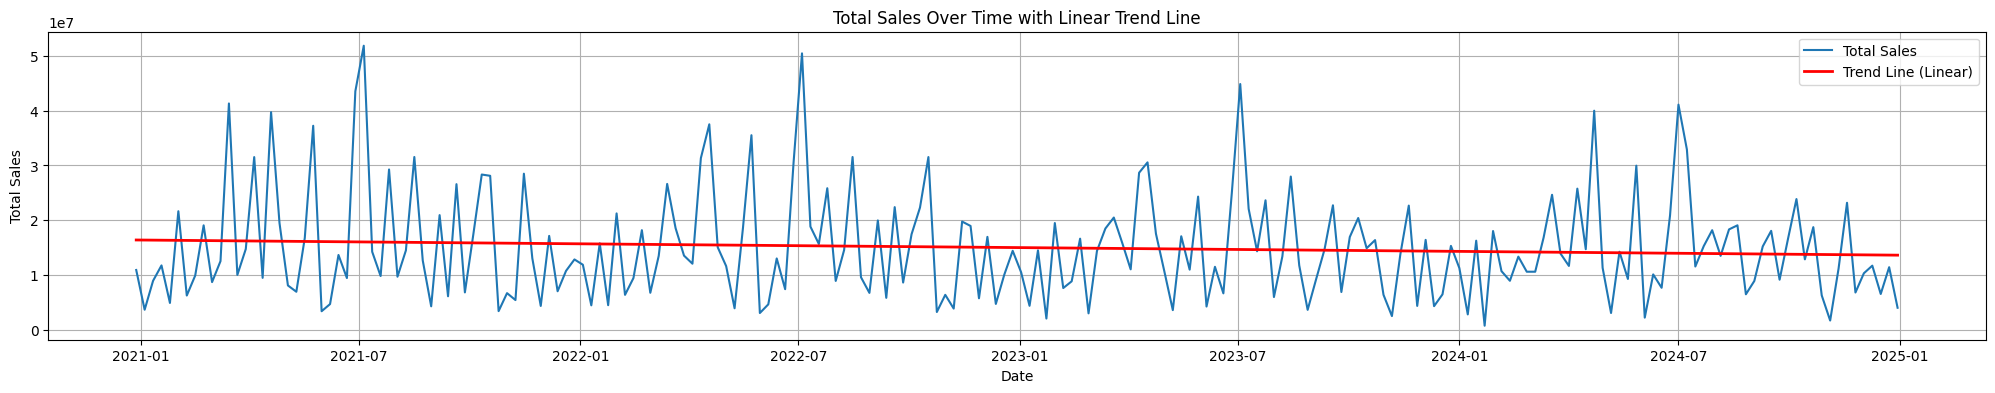

In [193]:
### Draw a time series plot of the total sales with a linear trend line
# Ensure the index is sorted by date
df_use = df_use.sort_index()

# Create a numeric time index for regression
df_use['time_index'] = range(len(df_use))

# Fit a linear regression model for the trend
model = LinearRegression()
model.fit(df_use[['time_index']], df_use['total_sales'])
df_use['trend'] = model.predict(df_use[['time_index']])

# Plot total sales and the trend line
plt.figure(figsize=(25, 4))
plt.plot(df_use.index, df_use['total_sales'], label='Total Sales')
plt.plot(df_use.index, df_use['trend'], color='red', linewidth=2, label='Trend Line (Linear)')
plt.title('Total Sales Over Time with Linear Trend Line')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()

In [200]:
df_use['year'] = df_use.index.year
df_use['week'] = df_use.index.isocalendar().week
df_use = df_use.iloc[1:-1]

In [201]:
df_use 

,total_sales,time_index,trend,year,week
week_date,,,,,
2021-01-04,3686279.86,1,1.638998e+07,2021,1
2021-01-11,8965000.12,2,1.637675e+07,2021,2
2021-01-18,11766983.19,3,1.636351e+07,2021,3
2021-01-25,4926779.37,4,1.635028e+07,2021,4
2021-02-01,21646899.18,5,1.633705e+07,2021,5
...,...,...,...,...,...
2024-11-25,6827167.31,204,1.370353e+07,2024,48
2024-12-02,10336712.38,205,1.369029e+07,2024,49
2024-12-09,11722276.42,206,1.367706e+07,2024,50


In [ ]:
df_use = df_use.iloc[1:-1]

In [202]:
df_use 

,total_sales,time_index,trend,year,week
week_date,,,,,
2021-01-04,3686279.86,1,1.638998e+07,2021,1
2021-01-11,8965000.12,2,1.637675e+07,2021,2
2021-01-18,11766983.19,3,1.636351e+07,2021,3
2021-01-25,4926779.37,4,1.635028e+07,2021,4
2021-02-01,21646899.18,5,1.633705e+07,2021,5
...,...,...,...,...,...
2024-11-25,6827167.31,204,1.370353e+07,2024,48
2024-12-02,10336712.38,205,1.369029e+07,2024,49
2024-12-09,11722276.42,206,1.367706e+07,2024,50


/var/folders/g9/0qzz7y_x0hv9n3vm26f0d_2w0000gn/T/ipykernel_59366/2944623182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_use['normalized_sales'] = df_use.groupby('year')['total_sales'].transform(


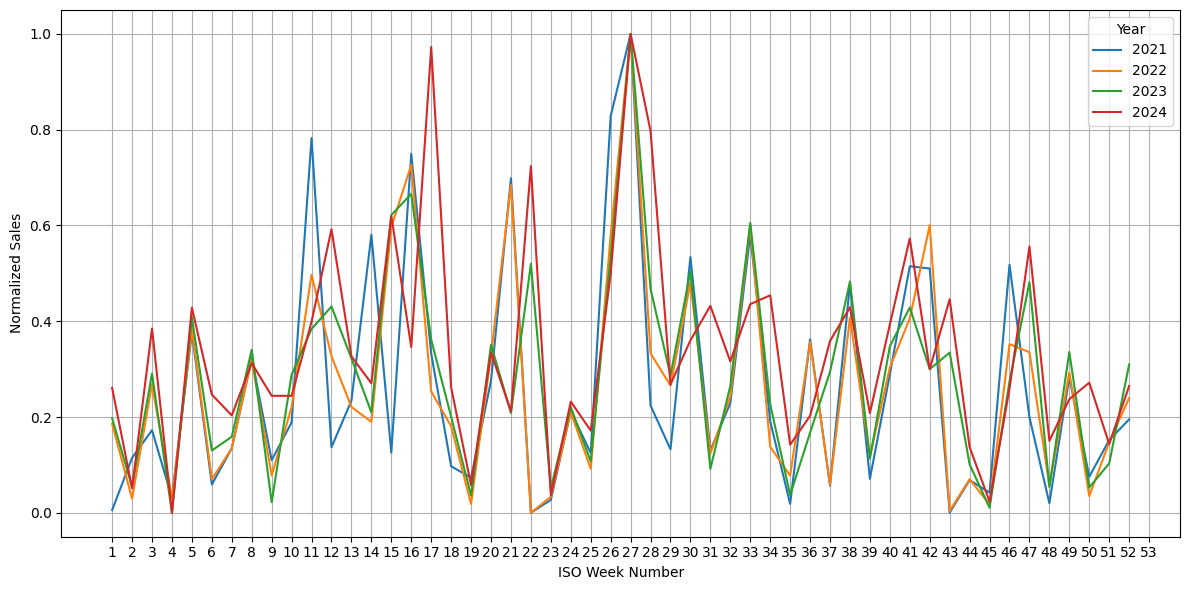

In [ ]:
### Normalize the total sales within each year
# This will allow us to compare the sales movement across different years
df_use['normalized_sales'] = df_use.groupby('year')['total_sales'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Plot normalized sales per ISO week for each year
plt.figure(figsize=(12, 6))
for year in df_use['year'].unique():
    subset = df_use[df_use['year'] == year]
    plt.plot(subset['week'], subset['normalized_sales'], label=str(year))

#plt.title("Normalized Weekly Sales Movement Compared Across Years")
plt.xlabel("ISO Week Number")
plt.ylabel("Normalized Sales")
plt.xticks(range(1, 54))
plt.legend(title="Year")
plt.grid(True)
plt.tight_layout()
plt.show()

In [207]:
# Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity
# This test will help us determine if the time series is stationary or not
from statsmodels.tsa.stattools import adfuller
import pandas as pd

#ADF test
result = adfuller(df_use['total_sales'].dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] < 0.05:
    print("The series is stationary (reject H0).")
else:
    print("The series is non-stationary (fail to reject H0).")


ADF Statistic: -5.175406
p-value: 0.000010
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.575
The series is stationary (reject H0).


## STL 

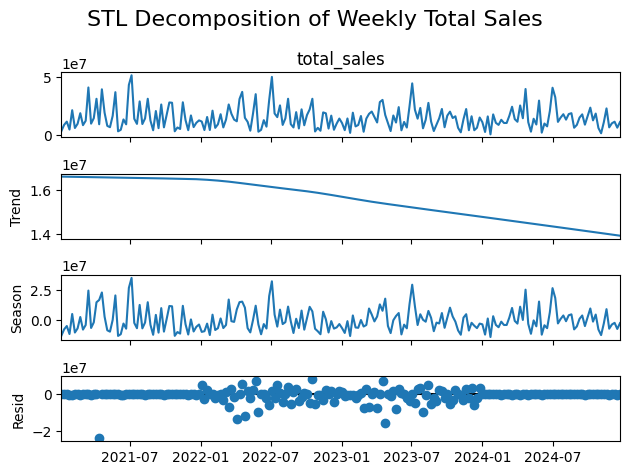

In [209]:
# Perform STL decomposition to analyze the seasonal and trend components of the time series
# Apply STL decomposition
stl = STL(df_use['total_sales'], period=52, robust=True)
result = stl.fit()

# Plot the decomposition
result.plot()
plt.suptitle("STL Decomposition of Weekly Total Sales", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the strength of seasonality using the variance of the seasonal and residual components
# Extract seasonal and residual components
seasonal = result.seasonal
residual = result.resid

# Compute variances
var_resid = np.var(residual, ddof=1)
var_seasonal_plus_resid = np.var(seasonal + residual, ddof=1)

# Seasonality strength
seasonality_strength = 1 - (var_resid / var_seasonal_plus_resid)
print(f"Seasonality Strength: {seasonality_strength:.4f}")

if seasonality_strength > 0.5:
    print("The time series shows strong seasonality.")
else:
    print("The time series shows weak seasonality.")

Seasonality Strength: 0.8828
The time series exhibits strong seasonality.


### Signal construction


In [233]:
from scipy.signal import savgol_filter

In [234]:
# STEP 1: Smooth seasonal component
smoothed_seasonal = pd.Series(
    savgol_filter(seasonal.values, window_length=11, polyorder=2),
    index=seasonal.index)
# STEP 2: Calculate the first difference of the smoothed seasonal component
derivative = smoothed_seasonal.diff().fillna(0)
derivative_smoothed = derivative.rolling(window=5, center=True).mean().fillna(0)

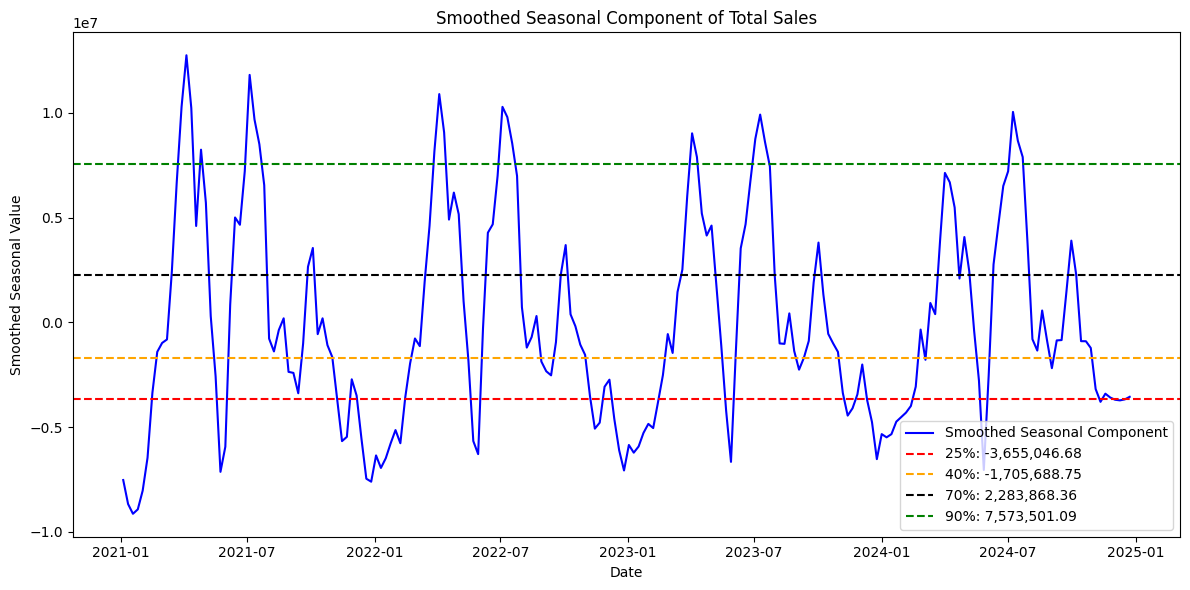

In [235]:
## Calculate quantiles for the smoothed seasonal component
q25 = smoothed_seasonal.quantile(0.25)
q40 = smoothed_seasonal.quantile(0.40)
q70 = smoothed_seasonal.quantile(0.70)
q90 = smoothed_seasonal.quantile(0.90)
#Plot the smoothed seasonal component
plt.figure(figsize=(12, 6))
plt.plot(smoothed_seasonal.index, smoothed_seasonal, label='Smoothed Seasonal Component', color='blue')
plt.title('Smoothed Seasonal Component of Total Sales')
plt.xlabel('Date')
plt.ylabel('Smoothed Seasonal Value')


plt.axhline(y=q25, color='red', linestyle='--', label=f'25%: {q25:,.2f}')
plt.axhline(y=q40, color='orange', linestyle='--', label=f'40%: {q40:,.2f}')
plt.axhline(y=q70, color='black', linestyle='--', label=f'70%: {q70:,.2f}')
plt.axhline(y=q90, color='green', linestyle='--', label=f'90%: {q90:,.2f}')

plt.legend()
plt.tight_layout()
plt.show()




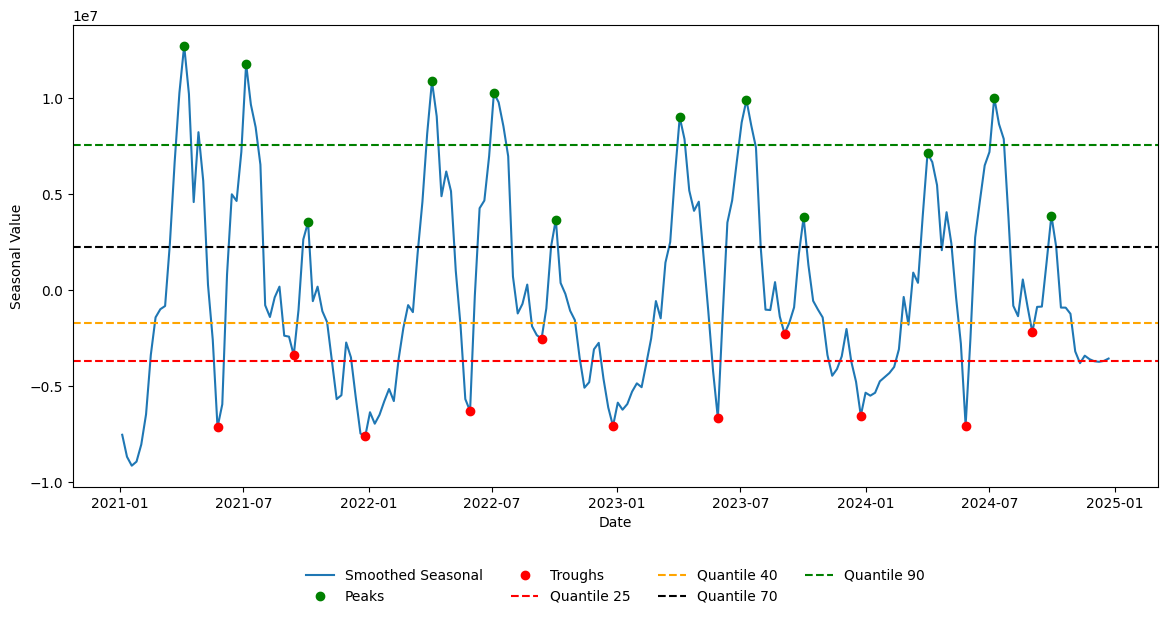

In [236]:
from scipy.signal import find_peaks

# STEP 3: Identify peaks and troughs in the smoothed seasonal component
# Use a prominence threshold to filter out insignificant peaks and troughs
# Calculate prominence based on the smoothed seasonal component
# This will help in identifying significant peaks and troughs

prominence = 0.2 * (smoothed_seasonal.max() - smoothed_seasonal.min())
peak_idxs, _ = find_peaks(smoothed_seasonal, prominence=prominence)
trough_idxs, _ = find_peaks(-smoothed_seasonal, prominence=prominence)

# 3️⃣ Mark them
plt.figure(figsize=(14, 6))
plt.plot(smoothed_seasonal, label='Smoothed Seasonal')
plt.plot(smoothed_seasonal.index[peak_idxs], smoothed_seasonal.iloc[peak_idxs], 'go', label='Peaks')
plt.plot(smoothed_seasonal.index[trough_idxs], smoothed_seasonal.iloc[trough_idxs], 'ro', label='Troughs')


plt.axhline(y=q25, color='red', linestyle='--', label= "Quantile 25")
plt.axhline(y=q40, color='orange', linestyle='--', label="Quantile 40")
plt.axhline(y=q70, color='black', linestyle='--', label="Quantile 70")
plt.axhline(y=q90, color='green', linestyle='--', label="Quantile 90")
plt.xlabel('Date')
plt.ylabel('Seasonal Value')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=False)
plt.show()

In [237]:
# STEP 4: Classify peaks and troughs into "high" and "small" categories
# Initialize a list to hold the phase labels for each point in the smoothed seasonal component
phases = [None] * len(smoothed_seasonal)
# Iterate through the identified peaks and troughs to classify them into categories based on the quantiles
for idx in peak_idxs:
    val = smoothed_seasonal.iloc[idx]
    if val >= q90:
        phase_label = 'high_peak'
        threshold_low = q90  # ≥ 90%
        threshold_high = np.inf  # no upper bound
    elif q70 <= val < q90:
        phase_label = 'small_peak'
        threshold_low = q70  # ≥ 70%
        threshold_high = q90  # but < 90%
    else:
        continue 
    # --- Identify whether surrounding points migh satisfied the threshold ---
    # --- Walk left and right until no long meeting threshold ---
    i = idx
    while (i >= 0 and 
           smoothed_seasonal.iloc[i] >= threshold_low and 
           smoothed_seasonal.iloc[i] < threshold_high):
        phases[i] = phase_label
        i -= 1

    i = idx + 1
    while (i < len(smoothed_seasonal) and 
           smoothed_seasonal.iloc[i] >= threshold_low and 
           smoothed_seasonal.iloc[i] < threshold_high):
        phases[i] = phase_label
        i += 1


for idx in trough_idxs:
    val = smoothed_seasonal.iloc[idx]

    if val <= q25:
        phase_label = 'high_trough'
        threshold_low = -np.inf  # no lower bound
        threshold_high = q25
    elif q25 < val <= q40:
        phase_label = 'small_trough'
        threshold_low = q25
        threshold_high = q40
    else:
        continue  
    # --- Identify whether surrounding points migh satisfied the threshold ---
    # --- Walk left and right until no long meeting thresholdd ---
    i = idx
    while i >= 0:
        v = smoothed_seasonal.iloc[i]
        if v >= threshold_low and v <= threshold_high:
            phases[i] = phase_label
            i -= 1
        else:
            break
    i = idx + 1
    while i < len(smoothed_seasonal):
        v = smoothed_seasonal.iloc[i]
        if v >= threshold_low and v <= threshold_high:
            phases[i] = phase_label
            i += 1
        else:
            break



In [238]:
# STEP 5: Classify the remaining points based on their values and derivatives
# Initialize the phases list with None for all points
# This will hold the phase labels for each point in the smoothed seasonal component
# Iterate through the smoothed seasonal component and classify the remaining points based on their values and derivatives
for i in range(len(smoothed_seasonal)):
    if phases[i] is not None:
        continue  # keep locked

    val = smoothed_seasonal.iloc[i]
    deriv = derivative_smoothed.iloc[i]
    if val < q25:
        phases[i] = 'high_trough'
    if q70<= val < q90:
        if deriv > 0:
            phases[i] = 'start_high_peak'
        elif deriv < 0:
            phases[i] = 'end_high_peak'

    elif q40 <= val < q70:
        if deriv > 0:
            phases[i] = 'start_small_peak'
        elif deriv < 0:
            phases[i] = 'end_small_peak'
    
    elif q25 < val <= q40:
        if deriv > 0:
            phases[i] = 'end_high_trough'
        elif deriv < 0:
            phases[i] = 'start_high_trough'

    


In [247]:
### Create a DataFrame to hold the smoothed seasonal component and its phases
# This DataFrame will contain the date, smoothed seasonal value, and the corresponding phase label
df_phases = pd.DataFrame({
    'date': smoothed_seasonal.index,
    'seasonal': smoothed_seasonal.values,
    'phase': phases  # your phase list: peak_high, small_low, start_peak_high, etc.
})
df_phases.loc[df_phases.index[-1], 'phase'] = df_phases.loc[df_phases.index[-2], 'phase']


In [241]:
# Since the last point might not have a valid phase, we can assign it the same phase as the second to last point
# This is a common practice to ensure the last point has a valid phase label 
df_phases.loc[df_phases.index[-1], 'phase'] = df_phases.loc[df_phases.index[-2], 'phase']


/var/folders/g9/0qzz7y_x0hv9n3vm26f0d_2w0000gn/T/ipykernel_59366/3954797826.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_phases['phase'] = pd.Series(df_phases['phase']).fillna(method='ffill').fillna(method='bfill')
/var/folders/g9/0qzz7y_x0hv9n3vm26f0d_2w0000gn/T/ipykernel_59366/3954797826.py:7: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df_phases['phase'] = df_phases['phase'].replace('unknown', method='ffill').replace('unknown', method='bfill')


Unique phases: ['high_trough' 'end_high_trough' 'start_small_peak' 'start_high_peak'
 'high_peak' 'end_high_peak' 'end_small_peak' 'start_high_trough'
 'small_trough' 'small_peak']


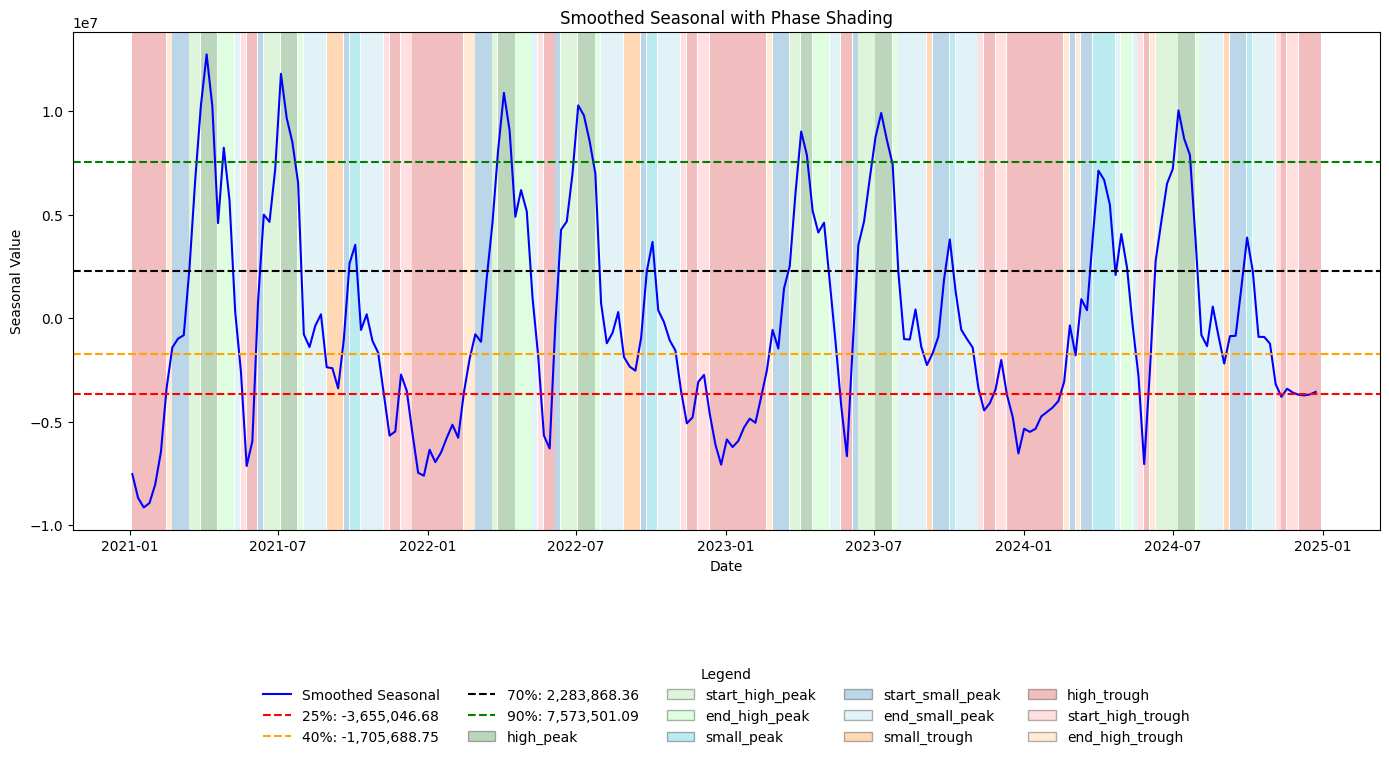

In [242]:
import pandas as pd
import matplotlib.pyplot as plt
# Visualize the phases 

# Fill any None, NaN, or 'unknown' by forward & backward fill
df_phases['phase'] = pd.Series(df_phases['phase']).fillna(method='ffill').fillna(method='bfill')
df_phases['phase'] = df_phases['phase'].replace('unknown', method='ffill').replace('unknown', method='bfill')

# Confirm
print('Unique phases:', df_phases['phase'].unique())

# ----------------------------------------
# Group contiguous runs
# ----------------------------------------
df_phases['phase_run'] = (df_phases['phase'] != df_phases['phase'].shift()).cumsum()

# ----------------------------------------
# Define the colors 
# ----------------------------------------
colors = {
    'high_peak': '#1f7a1f',   # darker green
    'start_high_peak': '#98df8a',     # light green
    'end_high_peak': '#98FB98',  # medium green
    'small_peak': '#17becf',        # teal
    'start_small_peak': '#1f78b4',  # medium teal
    'end_small_peak': '#9edae5',    # pale teal
    'small_trough': '#ff7f0e',         # orange
    'high_trough': '#d62728',
    'start_high_trough': '#ff9896',    # light red
    'end_high_trough': '#ffbb78'        # pale orange     
}


# ----------------------------------------
# Plot with shading
# ----------------------------------------
plt.figure(figsize=(14, 8))

# Main seasonal line
plt.plot(df_phases['date'], df_phases['seasonal'], label='Smoothed Seasonal', color='blue')

# Draw shaded blocks for each run
for _, run in df_phases.groupby('phase_run'):
    phase = run['phase'].iloc[0]
    if phase in colors:
        start = run['date'].iloc[0]
        end = run['date'].iloc[-1] + pd.Timedelta(days=6)  # extend to week end

        plt.axvspan(start, end, facecolor=colors[phase], alpha=0.3)


plt.axhline(y=q25, color='red', linestyle='--', label=f'25%: {q25:,.2f}')
plt.axhline(y=q40, color='orange', linestyle='--', label=f'40%: {q40:,.2f}')
plt.axhline(y=q70, color='black', linestyle='--', label=f'70%: {q70:,.2f}')
plt.axhline(y=q90, color='green', linestyle='--', label=f'90%: {q90:,.2f}')


plt.title('Smoothed Seasonal with Phase Shading')
plt.xlabel('Date')
plt.ylabel('Seasonal Value')

phase_patches = [
    Patch(facecolor=hex_color, edgecolor='k', label=phase,  alpha=0.3)
    for phase, hex_color in colors.items()
]
handles1, labels1 = plt.gca().get_legend_handles_labels()

# Combine: quantiles & line + phase colors
combined_handles = handles1 + phase_patches

# One combined legend BELOW the plot
plt.legend(handles=combined_handles,
           loc='upper center',
           bbox_to_anchor=(0.5, -0.25),
           ncol=5,
           title='Legend',
           frameon=False)

plt.tight_layout()
plt.show()

In [248]:
# Merge the phases with the original DataFrame
# This will allow us to analyze the total sales in relation to the identified phases
# Ensure the 'date' column is in datetime format and set it as the index
df_phases.set_index('date', inplace=True)
df_phases = df_phases[['phase']]
df_uses1 = df[['total_sales']]  # Keep only the 'phase' column
merged_df = df_uses1.merge(df_phases, left_index=True, right_index=True, how='inner')
merged_df.head()

,total_sales,phase
2021-01-04,3686279.86,high_trough
2021-01-11,8965000.12,high_trough
2021-01-18,11766983.19,high_trough
2021-01-25,4926779.37,high_trough
2021-02-01,21646899.18,high_trough


In [251]:
merged_df['phase'].unique()

array(['high_trough', 'end_high_trough', 'start_small_peak',
       'start_high_peak', 'high_peak', 'end_high_peak', None,
       'end_small_peak', 'start_high_trough', 'small_trough',
       'small_peak'], dtype=object)

In [253]:
phase_dummies

,phase_end_high_peak,phase_end_high_trough,phase_end_small_peak,phase_high_peak,phase_high_trough,phase_small_peak,phase_small_trough,phase_start_high_peak,phase_start_high_trough,phase_start_small_peak
2021-01-04,False,False,False,False,True,False,False,False,False,False
2021-01-11,False,False,False,False,True,False,False,False,False,False
2021-01-18,False,False,False,False,True,False,False,False,False,False
2021-01-25,False,False,False,False,True,False,False,False,False,False
2021-02-01,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2024-11-25,False,False,False,False,False,False,False,False,True,False
2024-12-02,False,False,False,False,True,False,False,False,False,False
2024-12-09,False,False,False,False,True,False,False,False,False,False
2024-12-16,False,False,False,False,True,False,False,False,False,False


In [254]:
# One-hot encode the 'phase' column
phase_dummies = pd.get_dummies(merged_df['phase'], prefix='phase')

# Concatenate the original DataFrame with the one-hot encoded columns
merged_df = pd.concat([merged_df, phase_dummies], axis=1)
merged_df.drop('phase_small_trough', axis=1, inplace=True)  # Drop the 'phase_small_low' column

# Display the updated DataFrame
print(merged_df.head())

            total_sales        phase  phase_end_high_peak  \
2021-01-04   3686279.86  high_trough                False   
2021-01-11   8965000.12  high_trough                False   
2021-01-18  11766983.19  high_trough                False   
2021-01-25   4926779.37  high_trough                False   
2021-02-01  21646899.18  high_trough                False   

            phase_end_high_trough  phase_end_small_peak  phase_high_peak  \
2021-01-04                  False                 False            False   
2021-01-11                  False                 False            False   
2021-01-18                  False                 False            False   
2021-01-25                  False                 False            False   
2021-02-01                  False                 False            False   

            phase_high_trough  phase_small_peak  phase_start_high_peak  \
2021-01-04               True             False                  False   
2021-01-11               Tru

# Modelling

In [256]:
### Define target and exogenous variables
target_col = 'total_sales'
exo_col = ['phase_end_peak_high', 'phase_end_peak_low',
       'phase_end_small_high', 'phase_peak_high', 'phase_peak_low',
       'phase_small_high', 'phase_start_peak_high', 'phase_start_peak_low',
       'phase_start_small_high']

### Split the data into training and testing sets
merged_df = merged_df.asfreq('W-Mon')
train_df = merged_df.loc[:'2024-06-24']
test_df = merged_df.loc['2024-06-24':]
test_df = test_df.iloc[1:]


In [257]:
# Function to calculate the Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    y_true = np.where(y_true == 0, 1e-10, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [258]:
# Function to calculate the Root Mean Squared Error (RMSE)
def r_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

## ARIMA

### Baseline ARIMA

/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


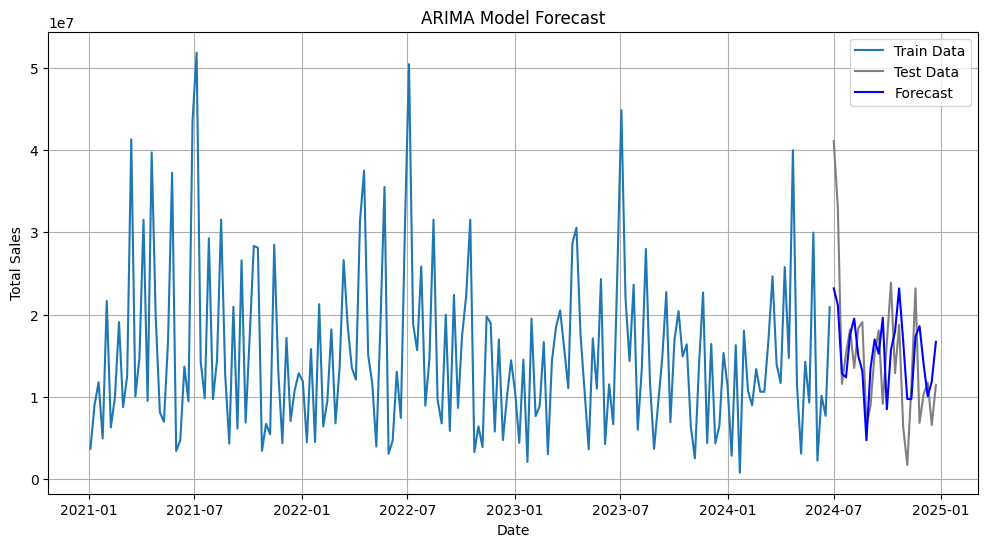

In [ ]:
### Baseline model fiting with order (20, 0, 3)

# Fit ARIMA model to the training data
arima_order = (20, 0, 3) 
model = ARIMA(train_df[target_col], order=arima_order)
results = model.fit()
# Forecast on the test set
forecast = results.forecast(steps=len(test_df[target_col]))

# Convert forecast to a pandas Series for easier handling
forecast_series = pd.Series(forecast, index=test_df.index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='blue')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


In [267]:
mape = mean_absolute_percentage_error(test_df[target_col], forecast_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], forecast_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 61.23%
RMSE: 7053986.14


### Optimal Parameters 

In [262]:
# Grid search for ARIMA parameters
# This will help us find the best ARIMA parameters based on AIC

p = range(0, 21) #run from 0 to 20
d = [0]
q = range(0, 5) # #run from 0 to 4

parameters = list(product(p, d, q))
best_aic = float("inf")
best_params = None
best_model = None

# Grid search
for param in parameters:
    try:
        model = ARIMA(train_df[target_col], order=param)
        model_fit = model.fit()

        aic = model_fit.aic

        if aic < best_aic:
            best_aic = aic
            best_params = param
            best_model = model_fit

        print(f"Tested ARIMA{param} - AIC: {aic:.4f}")
    except Exception as e:
        print(f"ARIMA{param} failed: {e}")

print("\nBest ARIMA parameters:", best_params)
print("Best AIC:", best_aic)

Tested ARIMA(0, 0, 0) - AIC: 7155.7096
Tested ARIMA(0, 0, 1) - AIC: 6390.9841
Tested ARIMA(0, 0, 2) - AIC: 6390.3131
Tested ARIMA(0, 0, 3) - AIC: 6391.4524
Tested ARIMA(0, 0, 4) - AIC: 6392.9717
Tested ARIMA(1, 0, 0) - AIC: 6391.1099
Tested ARIMA(1, 0, 1) - AIC: 6388.0096


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tested ARIMA(1, 0, 2) - AIC: 6390.9595
Tested ARIMA(1, 0, 3) - AIC: 6392.9758
Tested ARIMA(1, 0, 4) - AIC: 6394.5197
Tested ARIMA(2, 0, 0) - AIC: 6391.0232
Tested ARIMA(2, 0, 1) - AIC: 6390.9735
Tested ARIMA(2, 0, 2) - AIC: 6391.8447
Tested ARIMA(2, 0, 3) - AIC: 6376.5898
Tested ARIMA(2, 0, 4) - AIC: 6383.8588
Tested ARIMA(3, 0, 0) - AIC: 6392.6822
Tested ARIMA(3, 0, 1) - AIC: 6392.9553


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tested ARIMA(3, 0, 2) - AIC: 6394.8507


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(3, 0, 3) - AIC: 6374.7203
Tested ARIMA(3, 0, 4) - AIC: 6375.5561
Tested ARIMA(4, 0, 0) - AIC: 6393.1296
Tested ARIMA(4, 0, 1) - AIC: 6393.3819


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tested ARIMA(4, 0, 2) - AIC: 6388.0243


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(4, 0, 3) - AIC: 6375.7499


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Tested ARIMA(4, 0, 4) - AIC: 6367.1989
Tested ARIMA(5, 0, 0) - AIC: 6386.5240
Tested ARIMA(5, 0, 1) - AIC: 6386.5932
Tested ARIMA(5, 0, 2) - AIC: 6372.9847


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(5, 0, 3) - AIC: 6384.5382


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(5, 0, 4) - AIC: 6368.7412
Tested ARIMA(6, 0, 0) - AIC: 6383.3977
Tested ARIMA(6, 0, 1) - AIC: 6384.2805


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(6, 0, 2) - AIC: 6373.7286


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(6, 0, 3) - AIC: 6375.7088


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(6, 0, 4) - AIC: 6377.4385
Tested ARIMA(7, 0, 0) - AIC: 6382.4256
Tested ARIMA(7, 0, 1) - AIC: 6382.1068
Tested ARIMA(7, 0, 2) - AIC: 6382.1976


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(7, 0, 3) - AIC: 6375.9942


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(7, 0, 4) - AIC: 6378.8147
Tested ARIMA(8, 0, 0) - AIC: 6380.7667
Tested ARIMA(8, 0, 1) - AIC: 6382.6049


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(8, 0, 2) - AIC: 6372.2525


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(8, 0, 3) - AIC: 6383.0843


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(8, 0, 4) - AIC: 6375.7068
Tested ARIMA(9, 0, 0) - AIC: 6382.4750
Tested ARIMA(9, 0, 1) - AIC: 6384.4529
Tested ARIMA(9, 0, 2) - AIC: 6385.9892


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(9, 0, 3) - AIC: 6373.0150


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(9, 0, 4) - AIC: 6378.8352
Tested ARIMA(10, 0, 0) - AIC: 6384.2831
Tested ARIMA(10, 0, 1) - AIC: 6384.7873


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(10, 0, 2) - AIC: 6382.2004


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(10, 0, 3) - AIC: 6375.8466


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(10, 0, 4) - AIC: 6379.7499
Tested ARIMA(11, 0, 0) - AIC: 6385.2706
Tested ARIMA(11, 0, 1) - AIC: 6386.1721
Tested ARIMA(11, 0, 2) - AIC: 6384.8111


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(11, 0, 3) - AIC: 6382.5657


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(11, 0, 4) - AIC: 6377.6106
Tested ARIMA(12, 0, 0) - AIC: 6387.2342
Tested ARIMA(12, 0, 1) - AIC: 6388.1052


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(12, 0, 2) - AIC: 6386.5931


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(12, 0, 3) - AIC: 6384.5100


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(12, 0, 4) - AIC: 6383.0616
Tested ARIMA(13, 0, 0) - AIC: 6386.9852
Tested ARIMA(13, 0, 1) - AIC: 6388.0984


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(13, 0, 2) - AIC: 6380.1440


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(13, 0, 3) - AIC: 6376.8541


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(13, 0, 4) - AIC: 6379.4208
Tested ARIMA(14, 0, 0) - AIC: 6388.3188
Tested ARIMA(14, 0, 1) - AIC: 6389.9494


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(14, 0, 2) - AIC: 6381.5651


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(14, 0, 3) - AIC: 6379.3405


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(14, 0, 4) - AIC: 6376.7843
Tested ARIMA(15, 0, 0) - AIC: 6389.4785
Tested ARIMA(15, 0, 1) - AIC: 6391.4896


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(15, 0, 2) - AIC: 6386.3886


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(15, 0, 3) - AIC: 6384.4780


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(15, 0, 4) - AIC: 6385.1416
Tested ARIMA(16, 0, 0) - AIC: 6391.3891
Tested ARIMA(16, 0, 1) - AIC: 6393.2848


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(16, 0, 2) - AIC: 6386.9814


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(16, 0, 3) - AIC: 6380.4752


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(16, 0, 4) - AIC: 6384.5813
Tested ARIMA(17, 0, 0) - AIC: 6392.0744
Tested ARIMA(17, 0, 1) - AIC: 6381.8542
Tested ARIMA(17, 0, 2) - AIC: 6387.9883
Tested ARIMA(17, 0, 3) - AIC: 6384.2421


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(17, 0, 4) - AIC: 6382.5434
Tested ARIMA(18, 0, 0) - AIC: 6382.6521
Tested ARIMA(18, 0, 1) - AIC: 6384.2697
Tested ARIMA(18, 0, 2) - AIC: 6380.0338


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(18, 0, 3) - AIC: 6376.7333


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(18, 0, 4) - AIC: 6379.3458
Tested ARIMA(19, 0, 0) - AIC: 6384.6356
Tested ARIMA(19, 0, 1) - AIC: 6385.8759
Tested ARIMA(19, 0, 2) - AIC: 6381.9420


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(19, 0, 3) - AIC: 6377.4747


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(19, 0, 4) - AIC: 6377.4936
Tested ARIMA(20, 0, 0) - AIC: 6382.7123
Tested ARIMA(20, 0, 1) - AIC: 6384.7474


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(20, 0, 2) - AIC: 6369.8861


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(20, 0, 3) - AIC: 6371.2601


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(20, 0, 4) - AIC: 6379.1462

Best ARIMA parameters: (4, 0, 4)
Best AIC: 6367.198930042261


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


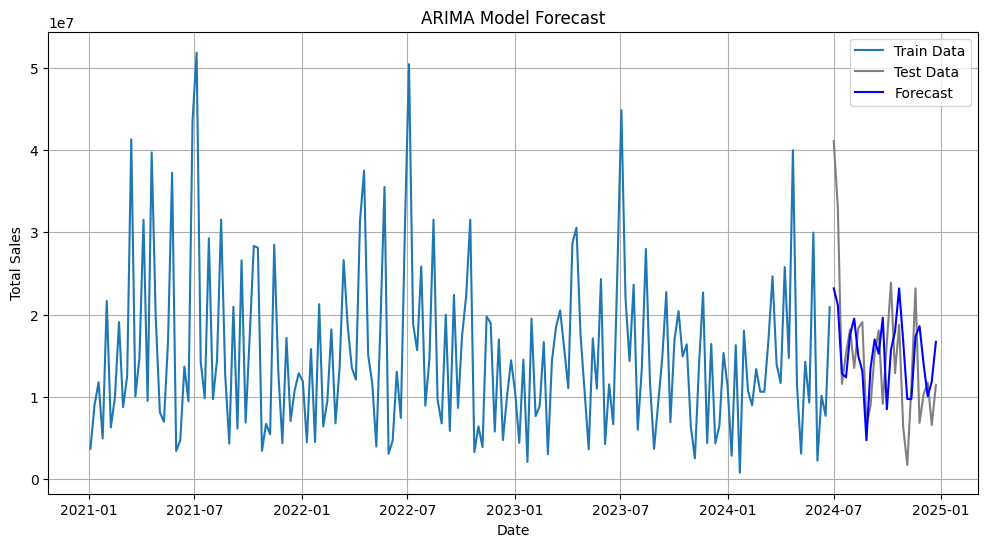

In [263]:
# Fit ARIMA model with optimal parameters
optimal_arima_order = (4, 0, 4)  
model = ARIMA(train_df[target_col], order= optimal_arima_order)
results = model.fit()
# Forecast on the test set
optimal_forecast = results.forecast(steps=len(test_df[target_col]))

# Convert forecast to a pandas Series for easier handling
forecast_optimal_series = pd.Series(optimal_forecast, index=test_df.index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(forecast_optimal_series.index, forecast_series, label='Forecast', color='blue')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


In [269]:
mape = mean_absolute_percentage_error(test_df[target_col], forecast_optimal_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], forecast_optimal_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 60.35%
RMSE: 7585453.26


## SARIMA

### Baseline (20,0,3)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74943D+01    |proj g|=  2.43301D-01

At iterate    5    f=  1.72976D+01    |proj g|=  2.90496D-02

At iterate   10    f=  1.72888D+01    |proj g|=  1.60988D-02

At iterate   15    f=  1.72515D+01    |proj g|=  2.37605D-02

At iterate   20    f=  1.72400D+01    |proj g|=  1.39201D-02

At iterate   25    f=  1.72394D+01    |proj g|=  6.24764D-04

At iterate   30    f=  1.72392D+01    |proj g|=  7.02056D-03

At iterate   35    f=  1.72382D+01    |proj g|=  5.98678D-03

At iterate   40    f=  1.72374D+01    |proj g|=  5.13818D-03

At iterate   45    f=  1.72364D+01    |proj g|=  1.44821D-02


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.72351D+01    |proj g|=  5.75332D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     63      1     0     0   5.753D-03   1.724D+01
  F =   17.235120857127331     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


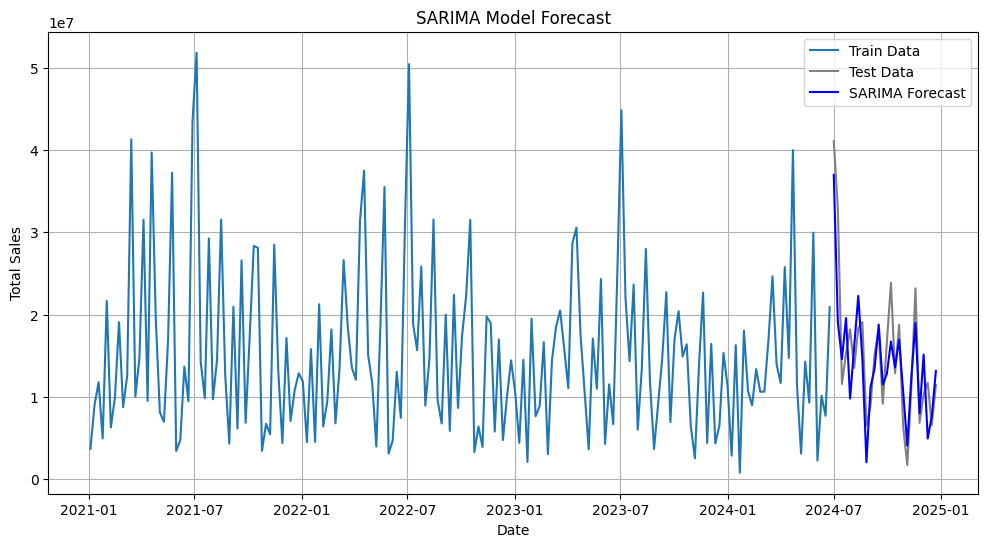

In [266]:
# Define SARIMA model parameters
sarima_order = (20, 0, 3)
seasonal_order = (1, 0, 1, 52)  # Assuming weekly seasonality (52 weeks per year)

# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_df[target_col], order=sarima_order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Forecast on the test set
sarima_forecast = sarima_results.forecast(steps=len(test_df))

# Convert forecast to a pandas Series for easier handling
sarima_forecast_series = pd.Series(sarima_forecast, index=test_df.index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(sarima_forecast_series.index, sarima_forecast_series, label='SARIMA Forecast', color='blue')
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
mape = mean_absolute_percentage_error(test_df[target_col], sarima_forecast_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], sarima_forecast_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 30.98%
MSE: 4680202.93


### Optimal parameters

In [46]:
# === 1️⃣ Your parameter ranges ===
p = range(0, 21)
d = [0]
q = range(0, 5)

P = range(0, 2)
D = [0]
Q = range(0, 2)
s = 52   # weekly data, so seasonal period is 52 weeks (1 year)

# === 2️⃣ Create parameter grid ===
parameters = list(product(p, d, q, P, D, Q))
print(f'Total parameter combinations: {len(parameters)}')

best_aic = float("inf")
best_params = None
best_model = None

# === 3️⃣ Grid search ===
for param in parameters:
    try:
        # Unpack
        p_, d_, q_, P_, D_, Q_ = param

        model = SARIMAX(
            train_df[target_col],
            order=(p_, d_, q_),
            seasonal_order=(P_, D_, Q_, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)

        aic = model_fit.aic

        if aic < best_aic:
            best_aic = aic
            best_params = param
            best_model = model_fit

        print(f"Tested SARIMA({p_},{d_},{q_}) x ({P_},{D_},{Q_},{s}) - AIC: {aic:.4f}")

    except Exception as e:
        print(f"SARIMA({param}) failed: {e}")

print("\n✅ Best SARIMA parameters:")
print(f"Non-seasonal: (p,d,q) = ({best_params[0]},{best_params[1]},{best_params[2]})")
print(f"Seasonal: (P,D,Q,s) = ({best_params[3]},{best_params[4]},{best_params[5]},{s})")
print(f"Best AIC: {best_aic:.4f}")


Total parameter combinations: 420
Tested SARIMA(0,0,0) x (0,0,0,52) - AIC: 6567.1758


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(0,0,0) x (0,0,1,52) - AIC: 20796268672.2469
Tested SARIMA(0,0,0) x (1,0,0,52) - AIC: 4414.9299
Tested SARIMA(0,0,0) x (1,0,1,52) - AIC: 20654900251.0340
Tested SARIMA(0,0,1) x (0,0,0,52) - AIC: 6470.0356


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(0,0,1) x (0,0,1,52) - AIC: 20715898130.7898
Tested SARIMA(0,0,1) x (1,0,0,52) - AIC: 4596.1238
Tested SARIMA(0,0,1) x (1,0,1,52) - AIC: 20574528311.8792
Tested SARIMA(0,0,2) x (0,0,0,52) - AIC: 6429.7940
Tested SARIMA(0,0,2) x (0,0,1,52) - AIC: 775214713812926.7500
Tested SARIMA(0,0,2) x (1,0,0,52) - AIC: 4603.1342


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(0,0,2) x (1,0,1,52) - AIC: 18664520853.5205
Tested SARIMA(0,0,3) x (0,0,0,52) - AIC: 6379.1040


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(0,0,3) x (0,0,1,52) - AIC: 20453304512.5739
Tested SARIMA(0,0,3) x (1,0,0,52) - AIC: 4604.4112
Tested SARIMA(0,0,3) x (1,0,1,52) - AIC: 20458379390.0334
Tested SARIMA(0,0,4) x (0,0,0,52) - AIC: 6342.5878
Tested SARIMA(0,0,4) x (0,0,1,52) - AIC: 20084574465.0033
Tested SARIMA(0,0,4) x (1,0,0,52) - AIC: 4603.0553


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(0,0,4) x (1,0,1,52) - AIC: 19819015405.9191
Tested SARIMA(1,0,0) x (0,0,0,52) - AIC: 6442.8338
Tested SARIMA(1,0,0) x (0,0,1,52) - AIC: 11711738628.7772
Tested SARIMA(1,0,0) x (1,0,0,52) - AIC: 4486.8484
Tested SARIMA(1,0,0) x (1,0,1,52) - AIC: 11700319636.2121
Tested SARIMA(1,0,1) x (0,0,0,52) - AIC: 6340.3547
Tested SARIMA(1,0,1) x (0,0,1,52) - AIC: 11669185350.4319
Tested SARIMA(1,0,1) x (1,0,0,52) - AIC: 4466.2962


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(1,0,1) x (1,0,1,52) - AIC: 11657685777.0580
Tested SARIMA(1,0,2) x (0,0,0,52) - AIC: 6303.9878


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(1,0,2) x (0,0,1,52) - AIC: 11634867988.6132
Tested SARIMA(1,0,2) x (1,0,0,52) - AIC: 4448.7752
Tested SARIMA(1,0,2) x (1,0,1,52) - AIC: 11394969814.2184
Tested SARIMA(1,0,3) x (0,0,0,52) - AIC: 6267.3609


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(1,0,3) x (0,0,1,52) - AIC: 11626950177.6860
Tested SARIMA(1,0,3) x (1,0,0,52) - AIC: 4453.6114


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(1,0,3) x (1,0,1,52) - AIC: 11615366679.4353
Tested SARIMA(1,0,4) x (0,0,0,52) - AIC: 6231.8932


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(1,0,4) x (0,0,1,52) - AIC: 11288326819.4844
Tested SARIMA(1,0,4) x (1,0,0,52) - AIC: 4451.6713


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(1,0,4) x (1,0,1,52) - AIC: 11276336622.0348
Tested SARIMA(2,0,0) x (0,0,0,52) - AIC: 6390.6212
Tested SARIMA(2,0,0) x (0,0,1,52) - AIC: 10728023948.0967
Tested SARIMA(2,0,0) x (1,0,0,52) - AIC: 4440.7695
Tested SARIMA(2,0,0) x (1,0,1,52) - AIC: 10668435504.2339
Tested SARIMA(2,0,1) x (0,0,0,52) - AIC: 6401.3834
Tested SARIMA(2,0,1) x (0,0,1,52) - AIC: 10495498424.6696
Tested SARIMA(2,0,1) x (1,0,0,52) - AIC: 4434.4079


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(2,0,1) x (1,0,1,52) - AIC: 10482379007.5264
Tested SARIMA(2,0,2) x (0,0,0,52) - AIC: 6355.4622


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(2,0,2) x (0,0,1,52) - AIC: 10508158735.2112
Tested SARIMA(2,0,2) x (1,0,0,52) - AIC: 4413.3803
Tested SARIMA(2,0,2) x (1,0,1,52) - AIC: 10507837487.5524
Tested SARIMA(2,0,3) x (0,0,0,52) - AIC: 6264.4201
Tested SARIMA(2,0,3) x (0,0,1,52) - AIC: 10623389050.0974
Tested SARIMA(2,0,3) x (1,0,0,52) - AIC: 4420.7174
Tested SARIMA(2,0,3) x (1,0,1,52) - AIC: 10616003436.7342
Tested SARIMA(2,0,4) x (0,0,0,52) - AIC: 6219.6392
Tested SARIMA(2,0,4) x (0,0,1,52) - AIC: 10369267089.6439
Tested SARIMA(2,0,4) x (1,0,0,52) - AIC: 4419.1927
Tested SARIMA(2,0,4) x (1,0,1,52) - AIC: 10361452365.0644
Tested SARIMA(3,0,0) x (0,0,0,52) - AIC: 6334.0142


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(3,0,0) x (0,0,1,52) - AIC: 8820020840.3590
Tested SARIMA(3,0,0) x (1,0,0,52) - AIC: 4394.2645
Tested SARIMA(3,0,0) x (1,0,1,52) - AIC: 8679855399.2862
Tested SARIMA(3,0,1) x (0,0,0,52) - AIC: 6305.7109
Tested SARIMA(3,0,1) x (0,0,1,52) - AIC: 8761060948.7282
Tested SARIMA(3,0,1) x (1,0,0,52) - AIC: 4396.5386
Tested SARIMA(3,0,1) x (1,0,1,52) - AIC: 8679855381.3975
Tested SARIMA(3,0,2) x (0,0,0,52) - AIC: 6356.8854


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(3,0,2) x (0,0,1,52) - AIC: 10848260624.1282
Tested SARIMA(3,0,2) x (1,0,0,52) - AIC: 4392.5991


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(3,0,2) x (1,0,1,52) - AIC: 12774511773.7419
Tested SARIMA(3,0,3) x (0,0,0,52) - AIC: 6265.4411
Tested SARIMA(3,0,3) x (0,0,1,52) - AIC: 8689434302.6397
Tested SARIMA(3,0,3) x (1,0,0,52) - AIC: 4385.8964


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(3,0,3) x (1,0,1,52) - AIC: 8677573875.3478


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(3,0,4) x (0,0,0,52) - AIC: 6221.2785
Tested SARIMA(3,0,4) x (0,0,1,52) - AIC: 8462753012.1772


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(3,0,4) x (1,0,0,52) - AIC: 4381.7231
Tested SARIMA(3,0,4) x (1,0,1,52) - AIC: 8450410748.9349
Tested SARIMA(4,0,0) x (0,0,0,52) - AIC: 6296.9210
Tested SARIMA(4,0,0) x (0,0,1,52) - AIC: 8739465054.3950
Tested SARIMA(4,0,0) x (1,0,0,52) - AIC: 4358.5181
Tested SARIMA(4,0,0) x (1,0,1,52) - AIC: 8594409282.5259
Tested SARIMA(4,0,1) x (0,0,0,52) - AIC: 6272.4849
Tested SARIMA(4,0,1) x (0,0,1,52) - AIC: 8678181863.5588
Tested SARIMA(4,0,1) x (1,0,0,52) - AIC: 4360.0160
Tested SARIMA(4,0,1) x (1,0,1,52) - AIC: 8594942436.8340
Tested SARIMA(4,0,2) x (0,0,0,52) - AIC: 6349.8215
Tested SARIMA(4,0,2) x (0,0,1,52) - AIC: 9276812555.8080


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(4,0,2) x (1,0,0,52) - AIC: 4410.4262


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(4,0,2) x (1,0,1,52) - AIC: 10233427388.7009


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(4,0,3) x (0,0,0,52) - AIC: 6258.2904
Tested SARIMA(4,0,3) x (0,0,1,52) - AIC: 8601264168.4767


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(4,0,3) x (1,0,0,52) - AIC: 4352.8698


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(4,0,3) x (1,0,1,52) - AIC: 8594408554.0995


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(4,0,4) x (0,0,0,52) - AIC: 6231.3500
Tested SARIMA(4,0,4) x (0,0,1,52) - AIC: 8366604904.0414
Tested SARIMA(4,0,4) x (1,0,0,52) - AIC: 4348.1426
Tested SARIMA(4,0,4) x (1,0,1,52) - AIC: 8359580180.0274
Tested SARIMA(5,0,0) x (0,0,0,52) - AIC: 6234.4214
Tested SARIMA(5,0,0) x (0,0,1,52) - AIC: 7548568658.4914
Tested SARIMA(5,0,0) x (1,0,0,52) - AIC: 4309.4057
Tested SARIMA(5,0,0) x (1,0,1,52) - AIC: 7042368339.8272
Tested SARIMA(5,0,1) x (0,0,0,52) - AIC: 6227.0586
Tested SARIMA(5,0,1) x (0,0,1,52) - AIC: 7485293596.0331
Tested SARIMA(5,0,1) x (1,0,0,52) - AIC: 4311.8242
Tested SARIMA(5,0,1) x (1,0,1,52) - AIC: 7042529050.1390
Tested SARIMA(5,0,2) x (0,0,0,52) - AIC: 6366.5663


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(5,0,2) x (0,0,1,52) - AIC: 7476778456.8442
Tested SARIMA(5,0,2) x (1,0,0,52) - AIC: 4377.0603


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(5,0,2) x (1,0,1,52) - AIC: 8742398032.6508
Tested SARIMA(5,0,3) x (0,0,0,52) - AIC: 6223.1945


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(5,0,3) x (0,0,1,52) - AIC: 7392664933.9781
Tested SARIMA(5,0,3) x (1,0,0,52) - AIC: 4304.4236
Tested SARIMA(5,0,3) x (1,0,1,52) - AIC: 7042369204.0332


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(5,0,4) x (0,0,0,52) - AIC: 6220.0003


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(5,0,4) x (0,0,1,52) - AIC: 7070642715.8886
Tested SARIMA(5,0,4) x (1,0,0,52) - AIC: 4306.3214


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(5,0,4) x (1,0,1,52) - AIC: 7042370934.3710
Tested SARIMA(6,0,0) x (0,0,0,52) - AIC: 6188.6358
Tested SARIMA(6,0,0) x (0,0,1,52) - AIC: 7048754287.3453
Tested SARIMA(6,0,0) x (1,0,0,52) - AIC: 4270.0568
Tested SARIMA(6,0,0) x (1,0,1,52) - AIC: 6481662171.8802
Tested SARIMA(6,0,1) x (0,0,0,52) - AIC: 6190.4074
Tested SARIMA(6,0,1) x (0,0,1,52) - AIC: 6979713178.9315
Tested SARIMA(6,0,1) x (1,0,0,52) - AIC: 4272.4836
Tested SARIMA(6,0,1) x (1,0,1,52) - AIC: 6481662330.8323
Tested SARIMA(6,0,2) x (0,0,0,52) - AIC: 6191.2845
Tested SARIMA(6,0,2) x (0,0,1,52) - AIC: 6870979134.1590
Tested SARIMA(6,0,2) x (1,0,0,52) - AIC: 4274.7192
Tested SARIMA(6,0,2) x (1,0,1,52) - AIC: 6481662789.5133
Tested SARIMA(6,0,3) x (0,0,0,52) - AIC: 6184.7542


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(6,0,3) x (0,0,1,52) - AIC: 6864806998.6028


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(6,0,3) x (1,0,0,52) - AIC: 4273.6644
Tested SARIMA(6,0,3) x (1,0,1,52) - AIC: 6481658920.5633
Tested SARIMA(6,0,4) x (0,0,0,52) - AIC: 6256.3242


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(6,0,4) x (0,0,1,52) - AIC: 8885783769.0396


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(6,0,4) x (1,0,0,52) - AIC: 4272.3946
Tested SARIMA(6,0,4) x (1,0,1,52) - AIC: 6466098311.2060
Tested SARIMA(7,0,0) x (0,0,0,52) - AIC: 6156.1183
Tested SARIMA(7,0,0) x (0,0,1,52) - AIC: 7048631683.1032
Tested SARIMA(7,0,0) x (1,0,0,52) - AIC: 4238.2124
Tested SARIMA(7,0,0) x (1,0,1,52) - AIC: 6449549493.0617
Tested SARIMA(7,0,1) x (0,0,0,52) - AIC: 6158.0659
Tested SARIMA(7,0,1) x (0,0,1,52) - AIC: 6979646982.2568
Tested SARIMA(7,0,1) x (1,0,0,52) - AIC: 4240.4727
Tested SARIMA(7,0,1) x (1,0,1,52) - AIC: 6449559254.4360
Tested SARIMA(7,0,2) x (0,0,0,52) - AIC: 6158.9868
Tested SARIMA(7,0,2) x (0,0,1,52) - AIC: 6870951577.0191
Tested SARIMA(7,0,2) x (1,0,0,52) - AIC: 4243.0174
Tested SARIMA(7,0,2) x (1,0,1,52) - AIC: 6449559110.8188


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(7,0,3) x (0,0,0,52) - AIC: 6144.1985


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(7,0,3) x (0,0,1,52) - AIC: 6864692817.7764


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(7,0,3) x (1,0,0,52) - AIC: 4238.8772
Tested SARIMA(7,0,3) x (1,0,1,52) - AIC: 6449558838.8761


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(7,0,4) x (0,0,0,52) - AIC: 6763.1891


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(7,0,4) x (0,0,1,52) - AIC: 8382476933776.2393
Tested SARIMA(7,0,4) x (1,0,0,52) - AIC: 4787.7814


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(7,0,4) x (1,0,1,52) - AIC: 7898353349009.2295
Tested SARIMA(8,0,0) x (0,0,0,52) - AIC: 6123.2705
Tested SARIMA(8,0,0) x (0,0,1,52) - AIC: 7023726098.3430
Tested SARIMA(8,0,0) x (1,0,0,52) - AIC: 4206.2289
Tested SARIMA(8,0,0) x (1,0,1,52) - AIC: 6408126804.8731
Tested SARIMA(8,0,1) x (0,0,0,52) - AIC: 6122.9585
Tested SARIMA(8,0,1) x (0,0,1,52) - AIC: 6954696120.9370
Tested SARIMA(8,0,1) x (1,0,0,52) - AIC: 4208.7316


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(8,0,1) x (1,0,1,52) - AIC: 6408227040.9433


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(8,0,2) x (0,0,0,52) - AIC: 6115.3258
Tested SARIMA(8,0,2) x (0,0,1,52) - AIC: 6847055164.7952
Tested SARIMA(8,0,2) x (1,0,0,52) - AIC: 4211.2753
Tested SARIMA(8,0,2) x (1,0,1,52) - AIC: 6408226945.5682


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(8,0,3) x (0,0,0,52) - AIC: 6123.6312
Tested SARIMA(8,0,3) x (0,0,1,52) - AIC: 6841729785.2701


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(8,0,3) x (1,0,0,52) - AIC: 4208.0343
Tested SARIMA(8,0,3) x (1,0,1,52) - AIC: 6408227695.8474


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(8,0,4) x (0,0,0,52) - AIC: 7001.6816


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(8,0,4) x (0,0,1,52) - AIC: nan


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(8,0,4) x (1,0,0,52) - AIC: 4579.5344


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(8,0,4) x (1,0,1,52) - AIC: 4064515447128.0415
Tested SARIMA(9,0,0) x (0,0,0,52) - AIC: 6090.2036
Tested SARIMA(9,0,0) x (0,0,1,52) - AIC: 7023535741.5167
Tested SARIMA(9,0,0) x (1,0,0,52) - AIC: 4174.1233
Tested SARIMA(9,0,0) x (1,0,1,52) - AIC: 6403403807.9987
Tested SARIMA(9,0,1) x (0,0,0,52) - AIC: 6085.0680
Tested SARIMA(9,0,1) x (0,0,1,52) - AIC: 6954523648.0174
Tested SARIMA(9,0,1) x (1,0,0,52) - AIC: 4176.6638


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(9,0,1) x (1,0,1,52) - AIC: 6403404402.4803


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(9,0,2) x (0,0,0,52) - AIC: 6087.9977


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(9,0,2) x (0,0,1,52) - AIC: 6846932952.5141


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(9,0,2) x (1,0,0,52) - AIC: 4174.7641
Tested SARIMA(9,0,2) x (1,0,1,52) - AIC: 6403404730.6812


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(9,0,3) x (0,0,0,52) - AIC: 6076.4514
Tested SARIMA(9,0,3) x (0,0,1,52) - AIC: 6841603138.5950


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(9,0,3) x (1,0,0,52) - AIC: 4173.8028


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(9,0,3) x (1,0,1,52) - AIC: 6403403980.2976
Tested SARIMA(9,0,4) x (0,0,0,52) - AIC: 7254.3314


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(9,0,4) x (0,0,1,52) - AIC: 4273815532.2826


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(9,0,4) x (1,0,0,52) - AIC: 4288.0112


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(9,0,4) x (1,0,1,52) - AIC: 32.0000
Tested SARIMA(10,0,0) x (0,0,0,52) - AIC: 6054.7372
Tested SARIMA(10,0,0) x (0,0,1,52) - AIC: 6881158094.6004
Tested SARIMA(10,0,0) x (1,0,0,52) - AIC: 4140.6415
Tested SARIMA(10,0,0) x (1,0,1,52) - AIC: 6211410460.7813
Tested SARIMA(10,0,1) x (0,0,0,52) - AIC: 6050.9632
Tested SARIMA(10,0,1) x (0,0,1,52) - AIC: 6812087390.9238
Tested SARIMA(10,0,1) x (1,0,0,52) - AIC: 4138.8285
Tested SARIMA(10,0,1) x (1,0,1,52) - AIC: 6211409478.7523


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(10,0,2) x (0,0,0,52) - AIC: 6044.4770


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(10,0,2) x (0,0,1,52) - AIC: 6704976985.0073
Tested SARIMA(10,0,2) x (1,0,0,52) - AIC: 4141.4336
Tested SARIMA(10,0,2) x (1,0,1,52) - AIC: 6211411096.8788


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(10,0,3) x (0,0,0,52) - AIC: 6039.5300
Tested SARIMA(10,0,3) x (0,0,1,52) - AIC: 6699964378.9608


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(10,0,3) x (1,0,0,52) - AIC: 4140.7544
Tested SARIMA(10,0,3) x (1,0,1,52) - AIC: 6211411768.5893
Tested SARIMA(10,0,4) x (0,0,0,52) - AIC: 6598.2726


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(10,0,4) x (0,0,1,52) - AIC: 8213481076.4113


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(10,0,4) x (1,0,0,52) - AIC: 4271.8583


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(10,0,4) x (1,0,1,52) - AIC: 9318775527.6388
Tested SARIMA(11,0,0) x (0,0,0,52) - AIC: 6010.2207


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(11,0,0) x (0,0,1,52) - AIC: 6877694773.0181
Tested SARIMA(11,0,0) x (1,0,0,52) - AIC: 4100.7005
Tested SARIMA(11,0,0) x (1,0,1,52) - AIC: 5384366630.4980
Tested SARIMA(11,0,1) x (0,0,0,52) - AIC: 6007.4106
Tested SARIMA(11,0,1) x (0,0,1,52) - AIC: 6808826004.7374


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(11,0,1) x (1,0,0,52) - AIC: 4103.0015
Tested SARIMA(11,0,1) x (1,0,1,52) - AIC: 5384366744.0949


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(11,0,2) x (0,0,0,52) - AIC: 6006.8522


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(11,0,2) x (0,0,1,52) - AIC: 6702251159.2187
Tested SARIMA(11,0,2) x (1,0,0,52) - AIC: 4104.9756
Tested SARIMA(11,0,2) x (1,0,1,52) - AIC: 5384367340.4701


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(11,0,3) x (0,0,0,52) - AIC: 6005.7946
Tested SARIMA(11,0,3) x (0,0,1,52) - AIC: 6697354189.8646


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(11,0,3) x (1,0,0,52) - AIC: 4106.2331


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(11,0,3) x (1,0,1,52) - AIC: 5384374218.7880
Tested SARIMA(11,0,4) x (0,0,0,52) - AIC: 6277.5747


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(11,0,4) x (0,0,1,52) - AIC: 6925375197.7401
Tested SARIMA(11,0,4) x (1,0,0,52) - AIC: 4346.3311


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(11,0,4) x (1,0,1,52) - AIC: 5692102982.0858
Tested SARIMA(12,0,0) x (0,0,0,52) - AIC: 5976.9886
Tested SARIMA(12,0,0) x (0,0,1,52) - AIC: 6877553490.0386
Tested SARIMA(12,0,0) x (1,0,0,52) - AIC: 4067.8585
Tested SARIMA(12,0,0) x (1,0,1,52) - AIC: 5362111911.8362
Tested SARIMA(12,0,1) x (0,0,0,52) - AIC: 5975.1068
Tested SARIMA(12,0,1) x (0,0,1,52) - AIC: 6808696128.1423
Tested SARIMA(12,0,1) x (1,0,0,52) - AIC: 4069.8898


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(12,0,1) x (1,0,1,52) - AIC: 5362186312.6706
Tested SARIMA(12,0,2) x (0,0,0,52) - AIC: 5974.6685
Tested SARIMA(12,0,2) x (0,0,1,52) - AIC: 6702092632.1416
Tested SARIMA(12,0,2) x (1,0,0,52) - AIC: 4070.9732
Tested SARIMA(12,0,2) x (1,0,1,52) - AIC: 5362187634.0742


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(12,0,3) x (0,0,0,52) - AIC: 5972.3052
Tested SARIMA(12,0,3) x (0,0,1,52) - AIC: 6697173893.7549
Tested SARIMA(12,0,3) x (1,0,0,52) - AIC: 4072.8510
Tested SARIMA(12,0,3) x (1,0,1,52) - AIC: 5362188141.6288


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(12,0,4) x (0,0,0,52) - AIC: 5970.5243


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(12,0,4) x (0,0,1,52) - AIC: 6334006467.6238


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(12,0,4) x (1,0,0,52) - AIC: 4071.4722
Tested SARIMA(12,0,4) x (1,0,1,52) - AIC: 5362188234.6517
Tested SARIMA(13,0,0) x (0,0,0,52) - AIC: 5939.9285
Tested SARIMA(13,0,0) x (0,0,1,52) - AIC: 6758151035.7383
Tested SARIMA(13,0,0) x (1,0,0,52) - AIC: 4033.4953
Tested SARIMA(13,0,0) x (1,0,1,52) - AIC: 5095816882.4050
Tested SARIMA(13,0,1) x (0,0,0,52) - AIC: 5940.1101
Tested SARIMA(13,0,1) x (0,0,1,52) - AIC: 6689337042.9207
Tested SARIMA(13,0,1) x (1,0,0,52) - AIC: 4033.3731
Tested SARIMA(13,0,1) x (1,0,1,52) - AIC: 5095833005.3787


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(13,0,2) x (0,0,0,52) - AIC: 5929.0281
Tested SARIMA(13,0,2) x (0,0,1,52) - AIC: 6583127244.1571
Tested SARIMA(13,0,2) x (1,0,0,52) - AIC: 4035.8821


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(13,0,2) x (1,0,1,52) - AIC: 5097121233.6538


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(13,0,3) x (0,0,0,52) - AIC: 5914.3541
Tested SARIMA(13,0,3) x (0,0,1,52) - AIC: 6577983478.1868


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(13,0,3) x (1,0,0,52) - AIC: 4035.4135


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(13,0,3) x (1,0,1,52) - AIC: 5095967703.4635


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(13,0,4) x (0,0,0,52) - AIC: 5913.8875
Tested SARIMA(13,0,4) x (0,0,1,52) - AIC: 6208485964.2513
Tested SARIMA(13,0,4) x (1,0,0,52) - AIC: 4037.9222
Tested SARIMA(13,0,4) x (1,0,1,52) - AIC: 5097054028.1805
Tested SARIMA(14,0,0) x (0,0,0,52) - AIC: 5903.1276
Tested SARIMA(14,0,0) x (0,0,1,52) - AIC: 6758030312.9045
Tested SARIMA(14,0,0) x (1,0,0,52) - AIC: 3997.0541
Tested SARIMA(14,0,0) x (1,0,1,52) - AIC: 4731329776.1444
Tested SARIMA(14,0,1) x (0,0,0,52) - AIC: 5904.0721
Tested SARIMA(14,0,1) x (0,0,1,52) - AIC: 6689180723.6020
Tested SARIMA(14,0,1) x (1,0,0,52) - AIC: 3995.1394
Tested SARIMA(14,0,1) x (1,0,1,52) - AIC: 4731330111.5264


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(14,0,2) x (0,0,0,52) - AIC: 5892.2805


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(14,0,2) x (0,0,1,52) - AIC: 6582846371.8084


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(14,0,2) x (1,0,0,52) - AIC: 3994.1454
Tested SARIMA(14,0,2) x (1,0,1,52) - AIC: 4731632201.8808


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(14,0,3) x (0,0,0,52) - AIC: 5878.1492
Tested SARIMA(14,0,3) x (0,0,1,52) - AIC: 6577664437.1499


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(14,0,3) x (1,0,0,52) - AIC: 3996.8830
Tested SARIMA(14,0,3) x (1,0,1,52) - AIC: 4731631602.9631


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(14,0,4) x (0,0,0,52) - AIC: 5884.8348
Tested SARIMA(14,0,4) x (0,0,1,52) - AIC: 6207950745.7515


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(14,0,4) x (1,0,0,52) - AIC: 3998.4303


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(14,0,4) x (1,0,1,52) - AIC: 4731335268.8285
Tested SARIMA(15,0,0) x (0,0,0,52) - AIC: 5869.1987
Tested SARIMA(15,0,0) x (0,0,1,52) - AIC: 6753781388.4163
Tested SARIMA(15,0,0) x (1,0,0,52) - AIC: 3961.3681
Tested SARIMA(15,0,0) x (1,0,1,52) - AIC: 4661621691.9924
Tested SARIMA(15,0,1) x (0,0,0,52) - AIC: 5871.2103


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(15,0,1) x (0,0,1,52) - AIC: 6684917145.5795
Tested SARIMA(15,0,1) x (1,0,0,52) - AIC: 3958.5225


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(15,0,1) x (1,0,1,52) - AIC: 4661623515.4382


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(15,0,2) x (0,0,0,52) - AIC: 5864.6145
Tested SARIMA(15,0,2) x (0,0,1,52) - AIC: 6578301528.1535
Tested SARIMA(15,0,2) x (1,0,0,52) - AIC: 3960.9788


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(15,0,2) x (1,0,1,52) - AIC: 4661622605.4044


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(15,0,3) x (0,0,0,52) - AIC: 5852.3489
Tested SARIMA(15,0,3) x (0,0,1,52) - AIC: 6572987777.6708


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(15,0,3) x (1,0,0,52) - AIC: 3963.4387


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(15,0,3) x (1,0,1,52) - AIC: 4661622286.3198


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(15,0,4) x (0,0,0,52) - AIC: 5851.0803
Tested SARIMA(15,0,4) x (0,0,1,52) - AIC: 6202046090.4826


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(15,0,4) x (1,0,0,52) - AIC: 3965.0145


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(15,0,4) x (1,0,1,52) - AIC: 4661643281.6950
Tested SARIMA(16,0,0) x (0,0,0,52) - AIC: 5830.2123
Tested SARIMA(16,0,0) x (0,0,1,52) - AIC: 6748025502.4129
Tested SARIMA(16,0,0) x (1,0,0,52) - AIC: 3924.7419
Tested SARIMA(16,0,0) x (1,0,1,52) - AIC: 3478927144.5913
Tested SARIMA(16,0,1) x (0,0,0,52) - AIC: 5832.1575
Tested SARIMA(16,0,1) x (0,0,1,52) - AIC: 6679146386.3457
Tested SARIMA(16,0,1) x (1,0,0,52) - AIC: 3926.4448
Tested SARIMA(16,0,1) x (1,0,1,52) - AIC: 3478933494.5517


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(16,0,2) x (0,0,0,52) - AIC: 5818.6508
Tested SARIMA(16,0,2) x (0,0,1,52) - AIC: 6572411316.8848
Tested SARIMA(16,0,2) x (1,0,0,52) - AIC: 3928.9721


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(16,0,2) x (1,0,1,52) - AIC: 3478930939.9943


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(16,0,3) x (0,0,0,52) - AIC: 5825.9043
Tested SARIMA(16,0,3) x (0,0,1,52) - AIC: 6566974803.2035


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(16,0,3) x (1,0,0,52) - AIC: 3930.9891
Tested SARIMA(16,0,3) x (1,0,1,52) - AIC: 3478927801.6814


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(16,0,4) x (0,0,0,52) - AIC: 5828.4773
Tested SARIMA(16,0,4) x (0,0,1,52) - AIC: 6194093932.5162


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(16,0,4) x (1,0,0,52) - AIC: 3933.3339


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(16,0,4) x (1,0,1,52) - AIC: 3478927718.9826
Tested SARIMA(17,0,0) x (0,0,0,52) - AIC: 5797.8046
Tested SARIMA(17,0,0) x (0,0,1,52) - AIC: 6491556205.8691
Tested SARIMA(17,0,0) x (1,0,0,52) - AIC: 3892.4660
Tested SARIMA(17,0,0) x (1,0,1,52) - AIC: 3421095494.7282
Tested SARIMA(17,0,1) x (0,0,0,52) - AIC: 5797.6760
Tested SARIMA(17,0,1) x (0,0,1,52) - AIC: 6423138707.6682
Tested SARIMA(17,0,1) x (1,0,0,52) - AIC: 3894.6128
Tested SARIMA(17,0,1) x (1,0,1,52) - AIC: 3421095462.0227


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(17,0,2) x (0,0,0,52) - AIC: 5792.4135
Tested SARIMA(17,0,2) x (0,0,1,52) - AIC: 6317597220.4243
Tested SARIMA(17,0,2) x (1,0,0,52) - AIC: 3896.7994
Tested SARIMA(17,0,2) x (1,0,1,52) - AIC: 3421095506.2161


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(17,0,3) x (0,0,0,52) - AIC: 5791.5388


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(17,0,3) x (0,0,1,52) - AIC: 6312552290.4351


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(17,0,3) x (1,0,0,52) - AIC: 3899.1353
Tested SARIMA(17,0,3) x (1,0,1,52) - AIC: 3421095526.9330


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(17,0,4) x (0,0,0,52) - AIC: 5794.2160
Tested SARIMA(17,0,4) x (0,0,1,52) - AIC: 5945081290.7030


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(17,0,4) x (1,0,0,52) - AIC: 3899.3652


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(17,0,4) x (1,0,1,52) - AIC: 3421100289.0021
Tested SARIMA(18,0,0) x (0,0,0,52) - AIC: 5757.8684
Tested SARIMA(18,0,0) x (0,0,1,52) - AIC: 5892931482.2983
Tested SARIMA(18,0,0) x (1,0,0,52) - AIC: 3856.3084
Tested SARIMA(18,0,0) x (1,0,1,52) - AIC: 3139928772.5124
Tested SARIMA(18,0,1) x (0,0,0,52) - AIC: 5758.0570
Tested SARIMA(18,0,1) x (0,0,1,52) - AIC: 5820805423.9157
Tested SARIMA(18,0,1) x (1,0,0,52) - AIC: 3858.1333


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(18,0,1) x (1,0,1,52) - AIC: 3139928786.7972


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(18,0,2) x (0,0,0,52) - AIC: 5757.2868
Tested SARIMA(18,0,2) x (0,0,1,52) - AIC: 5705687778.8240
Tested SARIMA(18,0,2) x (1,0,0,52) - AIC: 3860.6849
Tested SARIMA(18,0,2) x (1,0,1,52) - AIC: 3139929187.8306


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(18,0,3) x (0,0,0,52) - AIC: 5757.1633
Tested SARIMA(18,0,3) x (0,0,1,52) - AIC: 5697960785.4297


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(18,0,3) x (1,0,0,52) - AIC: 3860.4497
Tested SARIMA(18,0,3) x (1,0,1,52) - AIC: 3139928816.2786


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(18,0,4) x (0,0,0,52) - AIC: 5757.0956
Tested SARIMA(18,0,4) x (0,0,1,52) - AIC: 5330864042.7580


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(18,0,4) x (1,0,0,52) - AIC: 3858.2718
Tested SARIMA(18,0,4) x (1,0,1,52) - AIC: 3139929452.3279
Tested SARIMA(19,0,0) x (0,0,0,52) - AIC: 5723.8028
Tested SARIMA(19,0,0) x (0,0,1,52) - AIC: 5875988398.4352
Tested SARIMA(19,0,0) x (1,0,0,52) - AIC: 3823.6379
Tested SARIMA(19,0,0) x (1,0,1,52) - AIC: 3079615907.7904
Tested SARIMA(19,0,1) x (0,0,0,52) - AIC: 5725.0468
Tested SARIMA(19,0,1) x (0,0,1,52) - AIC: 5804838749.5306
Tested SARIMA(19,0,1) x (1,0,0,52) - AIC: 3826.1907
Tested SARIMA(19,0,1) x (1,0,1,52) - AIC: 3079615899.2784
Tested SARIMA(19,0,2) x (0,0,0,52) - AIC: 5726.9663
Tested SARIMA(19,0,2) x (0,0,1,52) - AIC: 5693204668.1747


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(19,0,2) x (1,0,0,52) - AIC: 3825.7432
Tested SARIMA(19,0,2) x (1,0,1,52) - AIC: 3079615965.9925


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(19,0,3) x (0,0,0,52) - AIC: 5725.9762
Tested SARIMA(19,0,3) x (0,0,1,52) - AIC: 5686676987.4871


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(19,0,3) x (1,0,0,52) - AIC: 3826.1326
Tested SARIMA(19,0,3) x (1,0,1,52) - AIC: 3079616106.4232


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(19,0,4) x (0,0,0,52) - AIC: 5702.1877
Tested SARIMA(19,0,4) x (0,0,1,52) - AIC: 5324034414.1423


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(19,0,4) x (1,0,0,52) - AIC: 3825.6324
Tested SARIMA(19,0,4) x (1,0,1,52) - AIC: 3079616115.2905
Tested SARIMA(20,0,0) x (0,0,0,52) - AIC: 5690.3937
Tested SARIMA(20,0,0) x (0,0,1,52) - AIC: 5875869609.1250
Tested SARIMA(20,0,0) x (1,0,0,52) - AIC: 3791.1941
Tested SARIMA(20,0,0) x (1,0,1,52) - AIC: 3037992815.5435
Tested SARIMA(20,0,1) x (0,0,0,52) - AIC: 5692.2889
Tested SARIMA(20,0,1) x (0,0,1,52) - AIC: 5804736232.9009
Tested SARIMA(20,0,1) x (1,0,0,52) - AIC: 3791.6584
Tested SARIMA(20,0,1) x (1,0,1,52) - AIC: 3037989947.0501
Tested SARIMA(20,0,2) x (0,0,0,52) - AIC: 5665.1473
Tested SARIMA(20,0,2) x (0,0,1,52) - AIC: 5693052016.8339
Tested SARIMA(20,0,2) x (1,0,0,52) - AIC: 3791.5270
Tested SARIMA(20,0,2) x (1,0,1,52) - AIC: 3037989929.1724


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(20,0,3) x (0,0,0,52) - AIC: 5672.5678
Tested SARIMA(20,0,3) x (0,0,1,52) - AIC: 5686452628.5637


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(20,0,3) x (1,0,0,52) - AIC: 3793.1882


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(20,0,3) x (1,0,1,52) - AIC: 3037990032.9963


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(20,0,4) x (0,0,0,52) - AIC: 5670.7956
Tested SARIMA(20,0,4) x (0,0,1,52) - AIC: 5321475018.3847


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested SARIMA(20,0,4) x (1,0,0,52) - AIC: 3795.9594
Tested SARIMA(20,0,4) x (1,0,1,52) - AIC: 3037991249.1921

✅ Best SARIMA parameters:
Non-seasonal: (p,d,q) = (9,0,4)
Seasonal: (P,D,Q,s) = (1,0,1,52)
Best AIC: 32.0000


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75510D+01    |proj g|=  1.70364D-01


 This problem is unconstrained.



At iterate    5    f=  1.73705D+01    |proj g|=  2.83752D-02

At iterate   10    f=  1.73560D+01    |proj g|=  5.18497D-02

At iterate   15    f=  1.73149D+01    |proj g|=  3.01351D-02

At iterate   20    f=  1.73044D+01    |proj g|=  6.19559D-03

At iterate   25    f=  1.73027D+01    |proj g|=  3.01919D-02

At iterate   30    f=  1.73001D+01    |proj g|=  1.20853D-02

At iterate   35    f=  1.72994D+01    |proj g|=  1.82021D-02

At iterate   40    f=  1.72992D+01    |proj g|=  1.01550D-02

At iterate   45    f=  1.72992D+01    |proj g|=  3.63735D-03


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.72991D+01    |proj g|=  2.83053D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     60      1     0     0   2.831D-03   1.730D+01
  F =   17.299126372577469     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


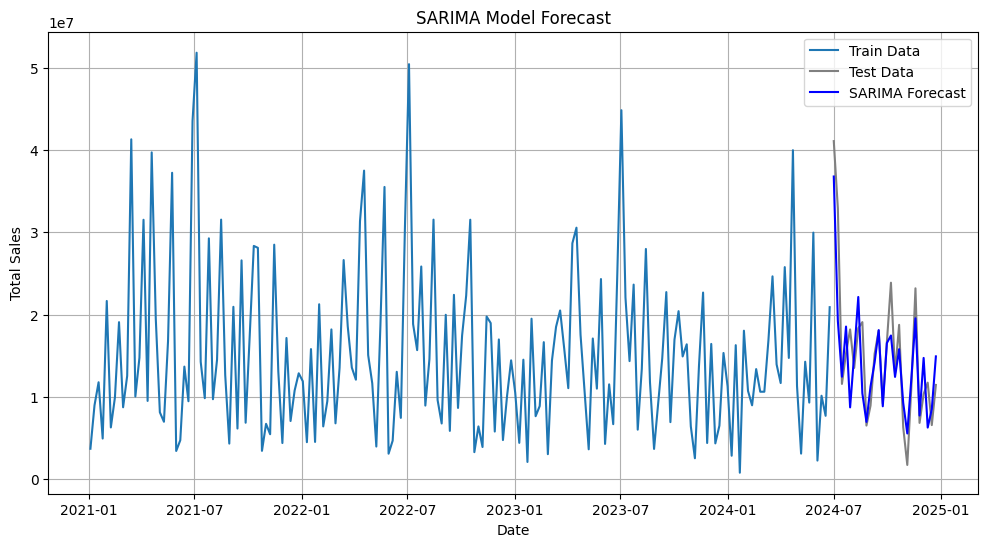

In [92]:
# Define SARIMA model parameters
o_sarima_order = (9, 0, 4)
o_seasonal_order = (1, 0, 1, 52)  # Assuming weekly seasonality (52 weeks per year)

# Fit SARIMA model to the training data
o_sarima_model = SARIMAX(train_df[target_col], order=o_sarima_order, seasonal_order=o_seasonal_order)
o_sarima_results = o_sarima_model.fit()

# Forecast on the test set
o_sarima_forecast = o_sarima_results.forecast(steps=len(test_df))

# Convert forecast to a pandas Series for easier handling
o_sarima_forecast_series = pd.Series(o_sarima_forecast, index=test_df.index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(o_sarima_forecast_series.index, o_sarima_forecast_series, label='SARIMA Forecast', color='blue')
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
mape = mean_absolute_percentage_error(test_df[target_col], o_sarima_forecast_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], o_sarima_forecast_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 29.17%
MSE: 4639952.85


## ARIMAX 

### Baseline (20,0,3)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73200D+01    |proj g|=  6.20903D-02


 This problem is unconstrained.



At iterate    5    f=  1.73146D+01    |proj g|=  1.31122D-02

At iterate   10    f=  1.73067D+01    |proj g|=  3.86751D-02

At iterate   15    f=  1.73029D+01    |proj g|=  1.82004D-02

At iterate   20    f=  1.72946D+01    |proj g|=  4.05399D-02

At iterate   25    f=  1.72857D+01    |proj g|=  4.07165D-02

At iterate   30    f=  1.72792D+01    |proj g|=  2.95036D-02

At iterate   35    f=  1.72770D+01    |proj g|=  7.78401D-02

At iterate   40    f=  1.72761D+01    |proj g|=  5.89315D-02

At iterate   45    f=  1.72754D+01    |proj g|=  7.71938D-03


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.72750D+01    |proj g|=  1.64218D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     54      1     0     0   1.642D-02   1.728D+01
  F =   17.275037029760796     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


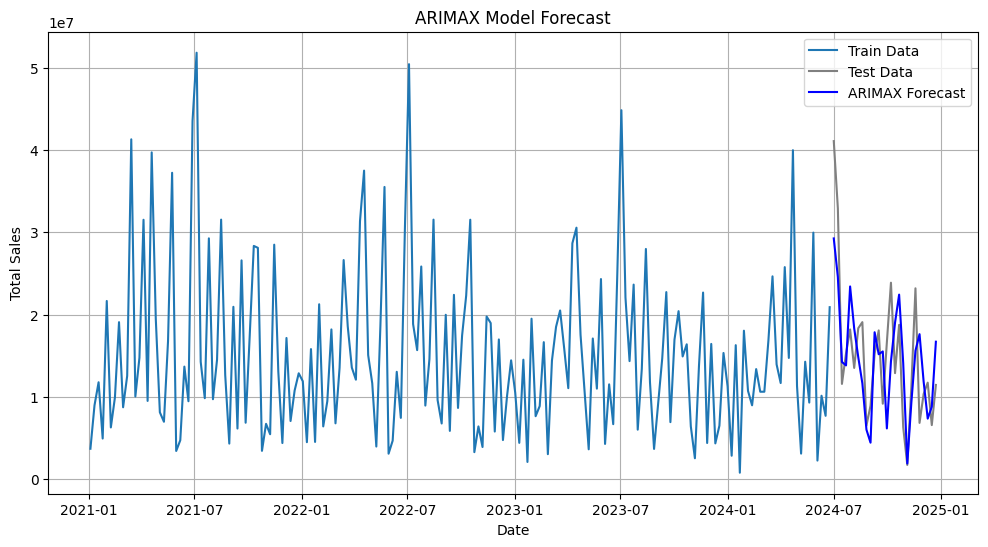

In [94]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit ARIMAX model
arimax_order = (20, 0, 3)  # Example order (p, d, q)
model_arimax = SARIMAX(train_df[target_col], exog=train_df[exo_col], order=arimax_order)
results_arimax = model_arimax.fit()

# Forecast on the test set
forecast_arimax = results_arimax.forecast(steps=len(test_df), exog=test_df[exo_col])

# Convert forecast to a pandas Series for easier handling
forecast_arimax_series = pd.Series(forecast_arimax, index=test_df.index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(forecast_arimax_series.index, forecast_arimax_series, label='ARIMAX Forecast', color='blue')
plt.title('ARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()



In [270]:
mape = mean_absolute_percentage_error(test_df[target_col], forecast_arimax_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], forecast_arimax_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 39.00%
RMSE: 6068315.75


### Optimal parameter

In [53]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# ----------------------------------------
# ✅ 1) Define your grid
# ----------------------------------------
p = range(0, 21)  # 0 to 20 inclusive
d = [0]           # fixed
q = range(0, 5)   # 0 to 4 inclusive

parameters = list(product(p, d, q))
print(f"Total combinations: {len(parameters)}")

# ----------------------------------------
# ✅ 2) Grid search
# ----------------------------------------
best_aic = float("inf")
best_params = None
best_model = None

for param in parameters:
    try:
        p_, d_, q_ = param

        model = SARIMAX(
            train_df[target_col],
            exog=train_df[exo_col],
            order=(p_, d_, q_),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)

        aic = results.aic

        if aic < best_aic:
            best_aic = aic
            best_params = param
            best_model = results

        print(f"Tested ARIMAX({p_},{d_},{q_}) - AIC: {aic:.2f}")

    except Exception as e:
        print(f"ARIMAX({p_},{d_},{q_}) failed: {e}")

print("\n✅ Best ARIMAX parameters:")
print(f"(p,d,q): ({best_params[0]},{best_params[1]},{best_params[2]})")
print(f"Best AIC: {best_aic:.2f}")


Total combinations: 105
Tested ARIMAX(0,0,0) - AIC: 7114.81
Tested ARIMAX(0,0,1) - AIC: 6320.34
Tested ARIMAX(0,0,2) - AIC: 6271.83
Tested ARIMAX(0,0,3) - AIC: 6238.49
Tested ARIMAX(0,0,4) - AIC: 6202.94
Tested ARIMAX(1,0,0) - AIC: 6354.82
Tested ARIMAX(1,0,1) - AIC: 6315.66
Tested ARIMAX(1,0,2) - AIC: 6273.62
Tested ARIMAX(1,0,3) - AIC: 6233.21
Tested ARIMAX(1,0,4) - AIC: 6197.95
Tested ARIMAX(2,0,0) - AIC: 6307.94
Tested ARIMAX(2,0,1) - AIC: 6305.79
Tested ARIMAX(2,0,2) - AIC: 6260.72
Tested ARIMAX(2,0,3) - AIC: 6220.92
Tested ARIMAX(2,0,4) - AIC: 6186.67
Tested ARIMAX(3,0,0) - AIC: 6272.45
Tested ARIMAX(3,0,1) - AIC: 6273.06
Tested ARIMAX(3,0,2) - AIC: 6260.11
Tested ARIMAX(3,0,3) - AIC: 6223.23
Tested ARIMAX(3,0,4) - AIC: 6179.99
Tested ARIMAX(4,0,0) - AIC: 6232.22
Tested ARIMAX(4,0,1) - AIC: 6231.19
Tested ARIMAX(4,0,2) - AIC: 6217.36
Tested ARIMAX(4,0,3) - AIC: 6216.87
Tested ARIMAX(4,0,4) - AIC: 6182.70
Tested ARIMAX(5,0,0) - AIC: 6189.48
Tested ARIMAX(5,0,1) - AIC: 6183.26
Test

/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(8,0,2) - AIC: 6076.37
Tested ARIMAX(8,0,3) - AIC: 6081.18
Tested ARIMAX(8,0,4) - AIC: 6079.76
Tested ARIMAX(9,0,0) - AIC: 6047.18
Tested ARIMAX(9,0,1) - AIC: 6048.52


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(9,0,2) - AIC: 6041.38


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(9,0,3) - AIC: 6039.87
Tested ARIMAX(9,0,4) - AIC: 6039.43
Tested ARIMAX(10,0,0) - AIC: 6014.58
Tested ARIMAX(10,0,1) - AIC: 6016.39


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(10,0,2) - AIC: 6007.76


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(10,0,3) - AIC: 6006.25


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(10,0,4) - AIC: 6003.80
Tested ARIMAX(11,0,0) - AIC: 5974.59
Tested ARIMAX(11,0,1) - AIC: 5976.07


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(11,0,2) - AIC: 5963.89


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(11,0,3) - AIC: 5966.66
Tested ARIMAX(11,0,4) - AIC: 5972.77
Tested ARIMAX(12,0,0) - AIC: 5941.93
Tested ARIMAX(12,0,1) - AIC: 5943.91
Tested ARIMAX(12,0,2) - AIC: 5945.92


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(12,0,3) - AIC: 5941.56


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(12,0,4) - AIC: 5932.02
Tested ARIMAX(13,0,0) - AIC: 5910.02
Tested ARIMAX(13,0,1) - AIC: 5912.02
Tested ARIMAX(13,0,2) - AIC: 5914.01


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(13,0,3) - AIC: 5909.69


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(13,0,4) - AIC: 5899.68
Tested ARIMAX(14,0,0) - AIC: 5877.80
Tested ARIMAX(14,0,1) - AIC: 5879.80
Tested ARIMAX(14,0,2) - AIC: 5881.82


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(14,0,3) - AIC: 5854.82


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(14,0,4) - AIC: 5869.34
Tested ARIMAX(15,0,0) - AIC: 5844.34
Tested ARIMAX(15,0,1) - AIC: 5846.31


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(15,0,2) - AIC: 5837.02
Tested ARIMAX(15,0,3) - AIC: 5829.11


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(15,0,4) - AIC: 5837.83
Tested ARIMAX(16,0,0) - AIC: 5809.01
Tested ARIMAX(16,0,1) - AIC: 5810.91


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(16,0,2) - AIC: 5802.63


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(16,0,3) - AIC: 5807.45


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(16,0,4) - AIC: 5793.38
Tested ARIMAX(17,0,0) - AIC: 5775.43
Tested ARIMAX(17,0,1) - AIC: 5774.18
Tested ARIMAX(17,0,2) - AIC: 5774.71


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(17,0,3) - AIC: 5771.03


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(17,0,4) - AIC: 5767.16
Tested ARIMAX(18,0,0) - AIC: 5736.27
Tested ARIMAX(18,0,1) - AIC: 5736.19
Tested ARIMAX(18,0,2) - AIC: 5738.10
Tested ARIMAX(18,0,3) - AIC: 5714.54
Tested ARIMAX(18,0,4) - AIC: 5720.77
Tested ARIMAX(19,0,0) - AIC: 5702.26
Tested ARIMAX(19,0,1) - AIC: 5702.86
Tested ARIMAX(19,0,2) - AIC: 5704.24
Tested ARIMAX(19,0,3) - AIC: 5686.19
Tested ARIMAX(19,0,4) - AIC: 5692.78
Tested ARIMAX(20,0,0) - AIC: 5665.51
Tested ARIMAX(20,0,1) - AIC: 5667.54
Tested ARIMAX(20,0,2) - AIC: 5657.60


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(20,0,3) - AIC: 5659.56
Tested ARIMAX(20,0,4) - AIC: 5654.94

✅ Best ARIMAX parameters:
(p,d,q): (20,0,4)
Best AIC: 5654.94


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73207D+01    |proj g|=  5.89337D-02


 This problem is unconstrained.



At iterate    5    f=  1.73146D+01    |proj g|=  2.15489D-02

At iterate   10    f=  1.73036D+01    |proj g|=  2.39153D-02

At iterate   15    f=  1.72999D+01    |proj g|=  2.16859D-02

At iterate   20    f=  1.72958D+01    |proj g|=  4.55563D-02

At iterate   25    f=  1.72907D+01    |proj g|=  1.93739D-01

At iterate   30    f=  1.72884D+01    |proj g|=  5.61723D-02

At iterate   35    f=  1.72877D+01    |proj g|=  2.75085D-02

At iterate   40    f=  1.72871D+01    |proj g|=  5.11052D-03

At iterate   45    f=  1.72867D+01    |proj g|=  2.13338D-02


/Users/camhabui/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.72865D+01    |proj g|=  4.76651D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     60      1     0     0   4.767D-02   1.729D+01
  F =   17.286499391567542     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


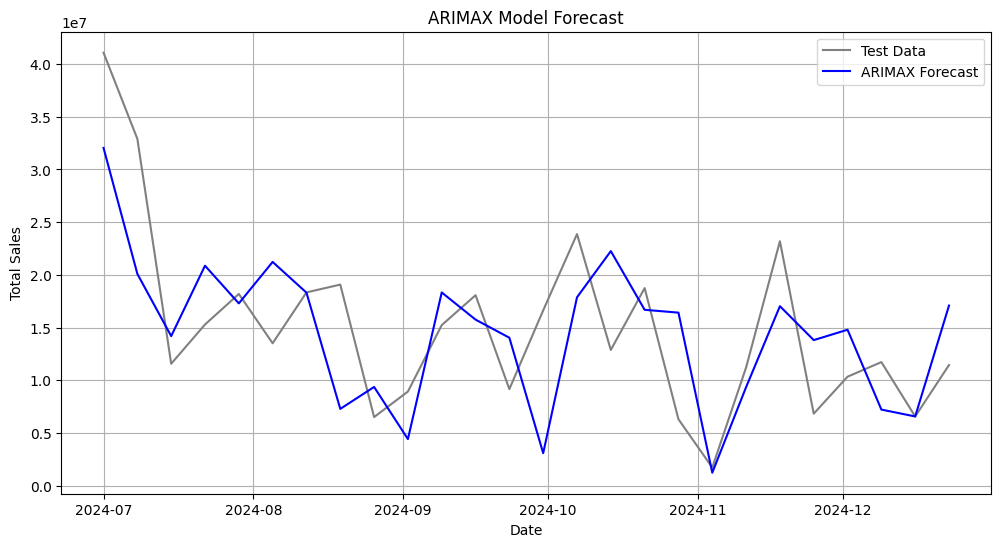

In [98]:
# Fit ARIMAX model
o_arimax_order = (20, 0, 4)  # Example order (p, d, q)
o_model_arimax = SARIMAX(train_df[target_col], exog=train_df[exo_col], order=o_arimax_order)
o_results_arimax = o_model_arimax.fit()

# Forecast on the test set
o_forecast_arimax = o_results_arimax.forecast(steps=len(test_df), exog=test_df[exo_col])

# Convert forecast to a pandas Series for easier handling
o_forecast_arimax_series = pd.Series(o_forecast_arimax, index=test_df.index)

# Plot the results
plt.figure(figsize=(12, 6))
#plt.plot(train_df.index, train_df[target_col], label='Train Data')
plt.plot(test_df.index, test_df[target_col], label='Test Data', color='gray')
plt.plot(o_forecast_arimax_series.index, o_forecast_arimax_series, label='ARIMAX Forecast', color='blue')
plt.title('ARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


In [271]:
mape = mean_absolute_percentage_error(test_df[target_col], o_forecast_arimax_series)
print(f"MAPE: {mape:.2f}%")
rmse = r_mean_squared_error(test_df[target_col], o_forecast_arimax_series)
print(f"RMSE: {rmse:.2f}")

MAPE: 41.58%
RMSE: 6584020.67


## Compare

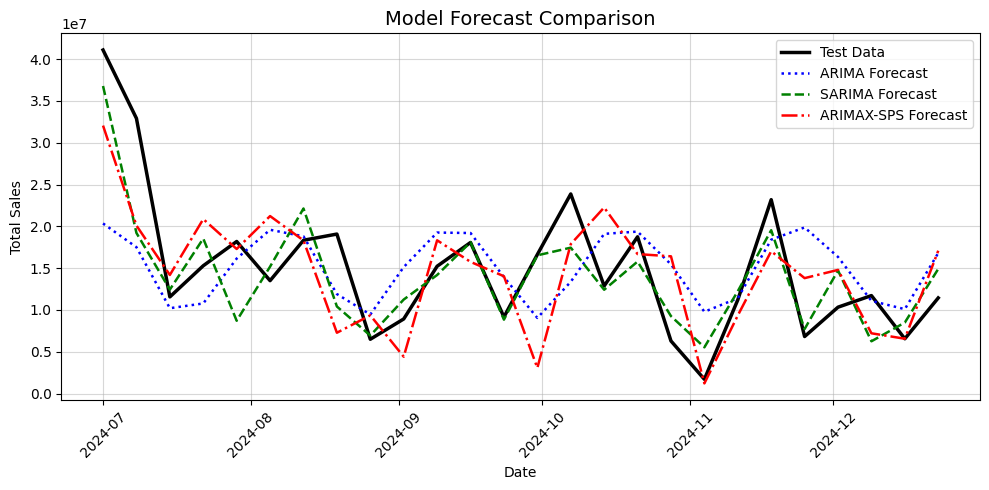

In [ ]:
# Plotting the results of the baseline models
# This will help us visualize the performance of the ARIMA, SARIMA, and ARIMAX models on the test data
plt.figure(figsize=(10, 5))

#Plot actual test data as a thick solid line
plt.plot(
    test_df.index, 
    test_df[target_col], 
    label='Test Data', 
    color='black', 
    linewidth=2.5
)

# Plot ARIMA forecast (blue, dotted)
plt.plot(
    forecast_optimal_series.index, 
    forecast_optimal_series, 
    label='ARIMA Forecast', 
    color='blue', 
    linestyle=':',
    linewidth=1.8
)

#  Plot SARIMA forecast (green, dashed)
plt.plot(
    o_sarima_forecast_series.index, 
    o_sarima_forecast_series, 
    label='SARIMA Forecast', 
    color='green', 
    linestyle='--',
    linewidth=1.8
)

#  Plot ARIMAX forecast (red, dash-dot)
plt.plot(
    o_forecast_arimax_series.index, 
    o_forecast_arimax_series, 
    label='ARIMAX-SPS Forecast', 
    color='red', 
    linestyle='-.',
    linewidth=1.8
)

#  Add title and labels
plt.title('Baseline Models Forecast Comparison', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Sales')

# Format x-axis: rotate 
plt.xticks(rotation=45)

#  Add grid and legend
plt.grid(True, alpha=0.5)
plt.legend(loc='upper right', fontsize=10)

# ✅ 8) Tight layout for clean margins
plt.tight_layout()

# ✅ 9) Show plot
plt.show()


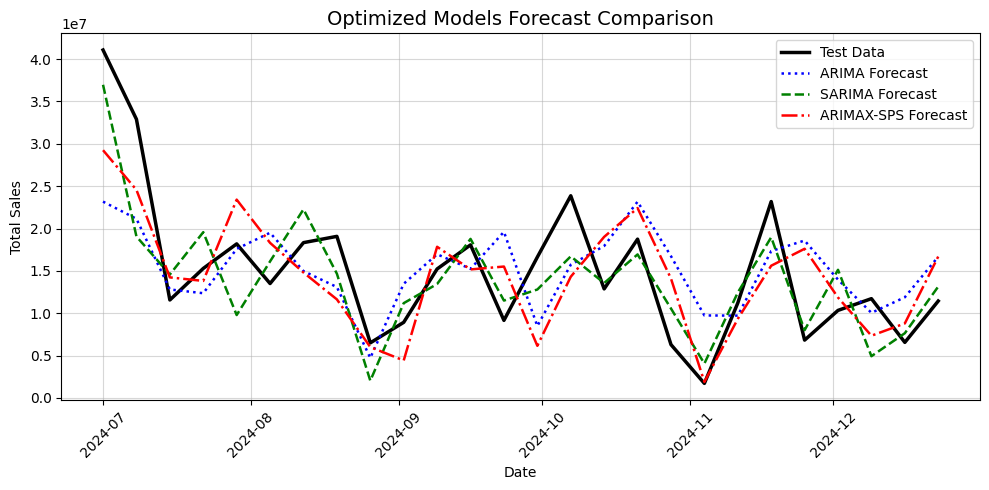

In [ ]:
# Plotting the results of the optimized models
# This will help us visualize the performance of the ARIMA, SARIMA, and ARIMAX models on the test data
plt.figure(figsize=(10, 5))

# Plot actual test data as a thick solid line
plt.plot(
    test_df.index, 
    test_df[target_col], 
    label='Test Data', 
    color='black', 
    linewidth=2.5
)

# Plot ARIMA forecast (blue, dotted)
plt.plot(
    forecast_series.index, 
    forecast_series, 
    label='ARIMA Forecast', 
    color='blue', 
    linestyle=':',
    linewidth=1.8
)

# Plot SARIMA forecast (green, dashed)
plt.plot(
    sarima_forecast_series.index, 
    sarima_forecast_series, 
    label='SARIMA Forecast', 
    color='green', 
    linestyle='--',
    linewidth=1.8
)

# Plot ARIMAX forecast (red, dash-dot)
plt.plot(
    forecast_arimax_series.index, 
    forecast_arimax_series, 
    label='ARIMAX-SPS Forecast', 
    color='red', 
    linestyle='-.',
    linewidth=1.8
)

# Add title and labels
plt.title('Optimized Models Forecast Comparison', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Sales')

# Format x-axis: rotate and use nice date labels
plt.xticks(rotation=45)

# Add grid and legend
plt.grid(True, alpha=0.5)
plt.legend(loc='upper right', fontsize=10)

# Tight layout for clean margins
plt.tight_layout()

# Show plot
plt.show()
